# House Prices - Advanced Regression Techiniques

<img src="download.png">

## Project Description

The main of this project is to develop a machine learning model that predicts house sale price taking into account some attributes.

The dataset is composed by 79 attributes, the first step is to select the most important characteristics to build the machine learning model.

First, I will check for outliers, elaborate and test some hypotesis and clean our dataset off with unnecessary variables.

Then, I will test some models as Simple Linear Regression, Linear Regression Regularized, Decision Tree Regressor, Random Forest Regressor and XGBoost. To avoid overfitting, I will check using cross validation.


link: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

## Lib's

Importing the necessary libraries 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge   
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif, mutual_info_regression

import xgboost as xgb

import time

pd.set_option('display.max_rows', None)
%matplotlib inline

## Creating Functions

select_features() was created to store the socres of the attributes, that way, I will be able to order them by its values.

prepare_input() was created to convert the discrete categorical variables into numerical. It uses OneHotEncoder and StandardScaler so that the variables have the same weights.

error_tab() creates a dataframe that will store the values of mean absolute error, mean absolute percentage error and squared root mean squerd error. 

cross_val_tab() creates a datafram that stores the values of mean scores for each model and the standard deviation.

seed() creates the seed that will be used in models as random_state, this makes that the output values are always the same.

right_skewed() defines if a distribution is right skewed or not, if its values is True, then the distribution is right skewed.

In [2]:
def select_features(X_train, y_train):
    """Uses the train data to select the bests attributes"""
    fs = SelectKBest(score_func = mutual_info_regression, k='all')
    fs.fit(X_train, y_train)
    return fs

def prepare_input(categorical):
    """Converts categorical discrete variables into numerical variables"""
    oe = OrdinalEncoder()
    oe.fit(categorical)
    categorical_final = oe.transform(categorical)
    onehotencoder = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), categorical_final)], remainder = 'passthrough')
    scaler= StandardScaler()
    categorical_final = scaler.fit_transform(categorical_final)
    return categorical_final

def error_tab(model_name, y, pred):
    """Calculates and creates a dataframe with the erros of the ML model"""
    mae = mean_absolute_error(y, pred)
    mape = mean_absolute_percentage_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))

    return pd.DataFrame({'Model Name' : model_name,
                        'MAE' : mae,
                        'MAPE' : mape,
                        'RMSE' : rmse
                        }, index = [0])

def cross_val_tab(model_name, model, x, y):
    """Calculates and creates a dataframe with the cross validation mean score and std."""
    cross = cross_validate(model, x, y, cv = 5)
    cv = cross['test_score'].mean(), cross['test_score'].std()
    return pd.DataFrame(cv, columns = [model_name], index = ['Mean', 'STD'])

def seed(num):
    SEED = num
    seed = np.random.seed(SEED)
    return seed

def right_skewed():

    mean = data['SalePrice'].mean()
    median = data['SalePrice'].median()
    mode = data['SalePrice'].mode()

    h = m = l = 0
    result = False

    if mean > median and median > mode[0]:
        h = mean
        m = median
        l = mode
        result = True
        
    elif mean < median and median < mode[0]:
        h = mode
        m = median
        l = mean
        result = False
        
    return result


## Importing the Dataset

In [3]:
train = pd.read_csv('train.csv')
data = train.copy()

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Now, let's see what are the types of each column.

In [5]:
data.shape

(1460, 81)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Not only we could see each type, but, if we compare with the number of rows (i.e, 1460), there are many null values in many columns.
We can count using the next code.

In [7]:
data.isnull().sum().sort_values(ascending = False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageCond         81
GarageType         81
GarageFinish       81
GarageQual         81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
Id                  0
Functional          0
Fireplaces          0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
TotRmsAbvGrd        0
GarageCars          0
GrLivArea           0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
BsmtFullBath        0
HeatingQC 

Now, we have to decide what to do with the missing numbers. We have 1460 rows in total, if we analyse PoolQC, there are 1453 null values, which means that we have information only of 7 houses with this attribute!

But, what does that means? Well, if only 0.5% of the data has this information, it will not add anything to the machine learning model, so, the best way to treat this kind of missing values is to delete it.

In [8]:
isnull = data.isnull().sum()
aux = pd.DataFrame(isnull[isnull > 0].sort_values(ascending = False), columns = ['attribute'])

aux['percentage'] = aux['attribute'].apply(lambda x : (x/data.shape[0] * 100))

aux

,attribute,percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


I decided to delete the columns which percentage > 30%. For the others attributes (i.e., percentage <= 30%) I decided to replace it by its mode.

* Note: Mode is the category or value that most repeat in the dataset.

In [9]:
data = data.drop(columns = aux[aux['percentage'] > 30].index)
aux2 = data.loc[:, aux[(aux['percentage'] <= 30)].index]

for column in aux2.columns:
    data[column].fillna(data[column].mode()[0], inplace = True)

## Splitting Numerical and Categorical attributes

It is necessary to separate the numerical attributes for those categorical. To avoid overfitting it is necessary to work in the data dimension. As the dataset has 79 different variables, using all of them  will result in a complex machine learning model. 

For each column, we will analyse the relative frequency of them. Those with a high frequency means that the data is very unbalanced. If the frequency is higher than 80%, I will drop the column.

After reading the data descreption text archieve, I found out that the attribute 'MSSubClass', even being numeric, is a categorical attribute.
Here follows the description:

    MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

We must convert it to str.

In [10]:
data['MSSubClass'] = data['MSSubClass'].astype('str')
train['MSSubClass'] = train['MSSubClass'].astype('str')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [11]:
numerical = data.select_dtypes(include = ['int64', 'float64'])
categorical = data.select_dtypes(exclude = ['int64', 'float64'])

In [12]:
print(numerical.columns)
print(categorical.columns)

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC

It is important to know....

In [13]:
print(numerical.shape)
print(categorical.shape)

(1460, 37)
(1460, 39)


### Numerical Attributes

Let's now analyse the percentage of each attribute. For example: 'LowQualFinSF' has 94% of its results concentrated in one single value. It means that this variable won't add significative information to explain price variation. That said, it is better if we drop it.

In [14]:
cols = numerical.columns
for column in numerical[cols]:
    count = 0
    count = numerical[column].value_counts(normalize = True) * 100
    if max(count) >= 80:
        print(count[:3])

0      88.561644
180     0.342466
374     0.205479
Name: BsmtFinSF2, dtype: float64
0      98.219178
80      0.205479
360     0.136986
Name: LowQualFinSF, dtype: float64
0    94.383562
1     5.479452
2     0.136986
Name: BsmtHalfBath, dtype: float64
1    95.342466
2     4.452055
3     0.136986
Name: KitchenAbvGr, dtype: float64
0      85.753425
112     1.027397
96      0.410959
Name: EnclosedPorch, dtype: float64
0      98.356164
168     0.205479
144     0.136986
Name: 3SsnPorch, dtype: float64
0      92.054795
192     0.410959
120     0.342466
Name: ScreenPorch, dtype: float64
0      99.520548
512     0.068493
648     0.068493
Name: PoolArea, dtype: float64
0      96.438356
400     0.753425
500     0.547945
Name: MiscVal, dtype: float64


In [15]:
cols = numerical.columns
num_drop_cols = []

for column in numerical[cols]:
    count = 0
    count = numerical[column].value_counts(normalize = True) * 100
    if max(count) >= 80:
        num_drop_cols.append(column)

print(f'The dropped numerical columns were: {num_drop_cols}')

The dropped numerical columns were: ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [16]:
data = data.drop(num_drop_cols, axis = 1)
data.shape

(1460, 67)

### Categorical Attributes

Let's do the same for categorical attributes:

In [17]:
cols = categorical.columns
for column in categorical[cols]:
    count = 0
    count = categorical[column].value_counts(normalize = True) * 100
    if max(count) >= 80:
        print(count[:3])

Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64
Lvl    89.794521
Bnk     4.315068
HLS     3.424658
Name: LandContour, dtype: float64
AllPub    99.931507
NoSeWa     0.068493
Name: Utilities, dtype: float64
Gtl    94.657534
Mod     4.452055
Sev     0.890411
Name: LandSlope, dtype: float64
Norm      86.301370
Feedr      5.547945
Artery     3.287671
Name: Condition1, dtype: float64
Norm      98.972603
Feedr      0.410959
Artery     0.136986
Name: Condition2, dtype: float64
1Fam      83.561644
TwnhsE     7.808219
Duplex     3.561644
Name: BldgType, dtype: float64
CompShg    98.219178
Tar&Grv     0.753425
WdShngl     0.410959
Name: RoofMatl, dtype: float64
TA    87.808219
Gd    10.000000
Fa     1.917808
Name: ExterCond, dtype: float64
TA    92.328767
Gd     4.452055
Fa     3.082192
Name: BsmtCond, dtype: float64
Unf    88.630137
Rec     3.698630
LwQ     3.150685
Name: BsmtFinType2, dtype: float64
GasA    97.808219
GasW     1.232877
Grav     0.479452
Name: Heating, dtype: flo

In [18]:
cols = categorical.columns
cat_drop_cols = []

for column in categorical[cols]:
    count = 0
    count = categorical[column].value_counts(normalize = True) * 100
    if max(count) >= 80:
        cat_drop_cols.append(column)

cat_drop_cols

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [19]:
data = data.drop(cat_drop_cols, axis = 1)
data.shape

(1460, 47)

So the following numerical attributes were dropped: 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'.

And the categorical variables: 'Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition'.
 
 As we saw, we dropped the number of variables down to 47 so fa. This is important to make analysis simpler and less redundant.

## Exploratory Data Analisys

This step is done to find patterns and/or anomalies. With the EDA, the first hypotesis are made. 

Let's look how the houses prices are distributed in our dataset. For this, the best way is using a histogram. 


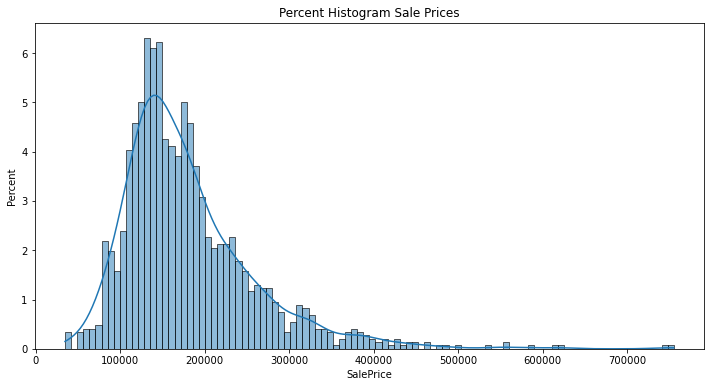

In [20]:
# house prices histogram

plt.figure(figsize = (12, 6))
sns.histplot(data = data['SalePrice'], stat = 'percent', kde = True, bins = 100)

plt.title('Percent Histogram Sale Prices');

In [21]:
sup = data[['SalePrice', 'GarageCars']]

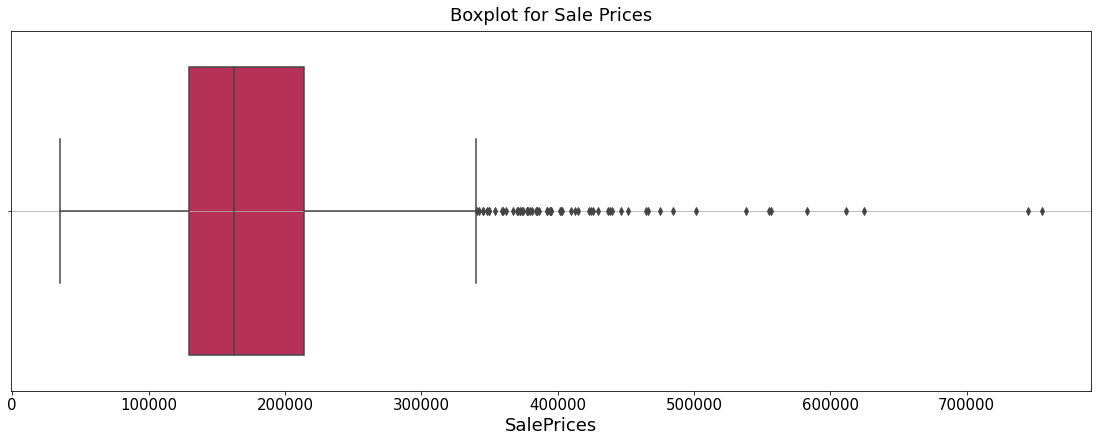

In [22]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = sup, x = 'SalePrice',  palette = 'rocket')
axis.set_title('Boxplot for Sale Prices', fontsize = 18, pad = 10)
axis.set_xlabel('SalePrices', fontsize = 18)

axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

It looks like a normal distribution, but it seems to be a right skewed distribution. We can see it if mode < median < mean using the right_skewed() function. As the result is True, it is a right skewed distribution.

In [23]:
right_skewed()

True

In [24]:
Q1 = np.percentile(data['SalePrice'], 25)
Q3 = np.percentile(data['SalePrice'], 75)
IQR = Q3 - Q1
print(f'IQR = {IQR}')
upper = (Q3 + 1.5 * IQR)
lower = (Q1 - 1.5 * IQR)
print(f'Upper bound = {upper}')
print(f'Lower bound = {lower}')


IQR = 84025.0
Upper bound = 340037.5
Lower bound = 3937.5


In [25]:
upper = np.where(data['SalePrice'] >= (Q3 + 1.5 * IQR))
lower = np.where(data['SalePrice'] <= (Q1 - 1.5 * IQR))

print(data.shape)
data.drop(upper[0], inplace = True)
data.drop(lower[0], inplace = True)
data.reset_index()
data.shape

(1460, 47)


(1399, 47)

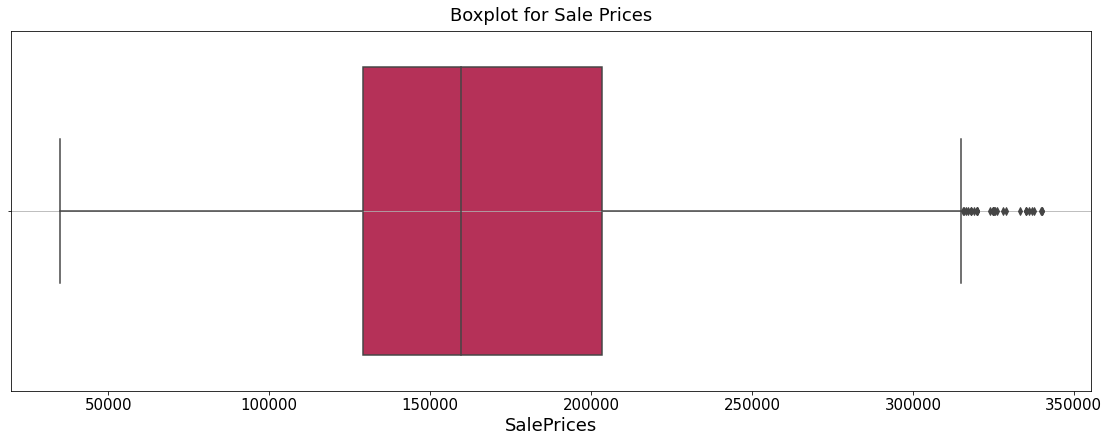

In [26]:
sup = data[['SalePrice', 'GarageCars']]
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = sup, x = 'SalePrice',  palette = 'rocket')
axis.set_title('Boxplot for Sale Prices', fontsize = 18, pad = 10)
axis.set_xlabel('SalePrices', fontsize = 18)

axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

In [27]:
right_skewed()

True

In [28]:
Q1 = np.percentile(data['SalePrice'], 25)
Q3 = np.percentile(data['SalePrice'], 75)
IQR = Q3 - Q1
print(f'IQR = {IQR}')
upper = (Q3 + 1.5 * IQR)
lower = (Q1 - 1.5 * IQR)
print(f'Upper bound = {upper}')
print(f'Lower bound = {lower}')

IQR = 74500.0
Upper bound = 315250.0
Lower bound = 17250.0


In [29]:
numerical = data.select_dtypes(include = ['int64', 'float64'])
categorical = data.select_dtypes(exclude = ['int64', 'float64'])
print(numerical.shape)
print(categorical.shape)

(1399, 28)
(1399, 19)


## Mean, median and mode for each attribute
### numerical attributes

Now, we will check up some central tendency values such as median, mean and mode. We will also ckeck some values of standard deviation, maximum, minimum and amplitude.

In [30]:
num_describe = numerical.describe().T
num_describe['amplitude'] = (num_describe['max'] - num_describe['min'])
num_describe = num_describe.drop(['25%', '50%', '75%'], axis = 1)
num_describe = num_describe.rename_axis('attributes').reset_index()
num_describe

,attributes,count,mean,std,min,max,amplitude
0,Id,1399.0,733.508935,422.811873,1.0,1460.0,1459.0
1,LotFrontage,1399.0,67.401001,21.806144,21.0,313.0,292.0
2,LotArea,1399.0,10155.280915,8324.834198,1300.0,164660.0,163360.0
3,OverallQual,1399.0,5.983560,1.282272,1.0,10.0,9.0
4,OverallCond,1399.0,5.591137,1.118236,1.0,9.0,8.0
5,YearBuilt,1399.0,1970.080772,30.009463,1872.0,2009.0,137.0
6,YearRemodAdd,1399.0,1984.058613,20.661160,1950.0,2010.0,60.0
7,MasVnrArea,1399.0,89.725518,159.219858,0.0,1600.0,1600.0
8,BsmtFinSF1,1399.0,417.333095,428.401771,0.0,5644.0,5644.0
9,BsmtUnfSF,1399.0,559.461758,429.378909,0.0,2042.0,2042.0


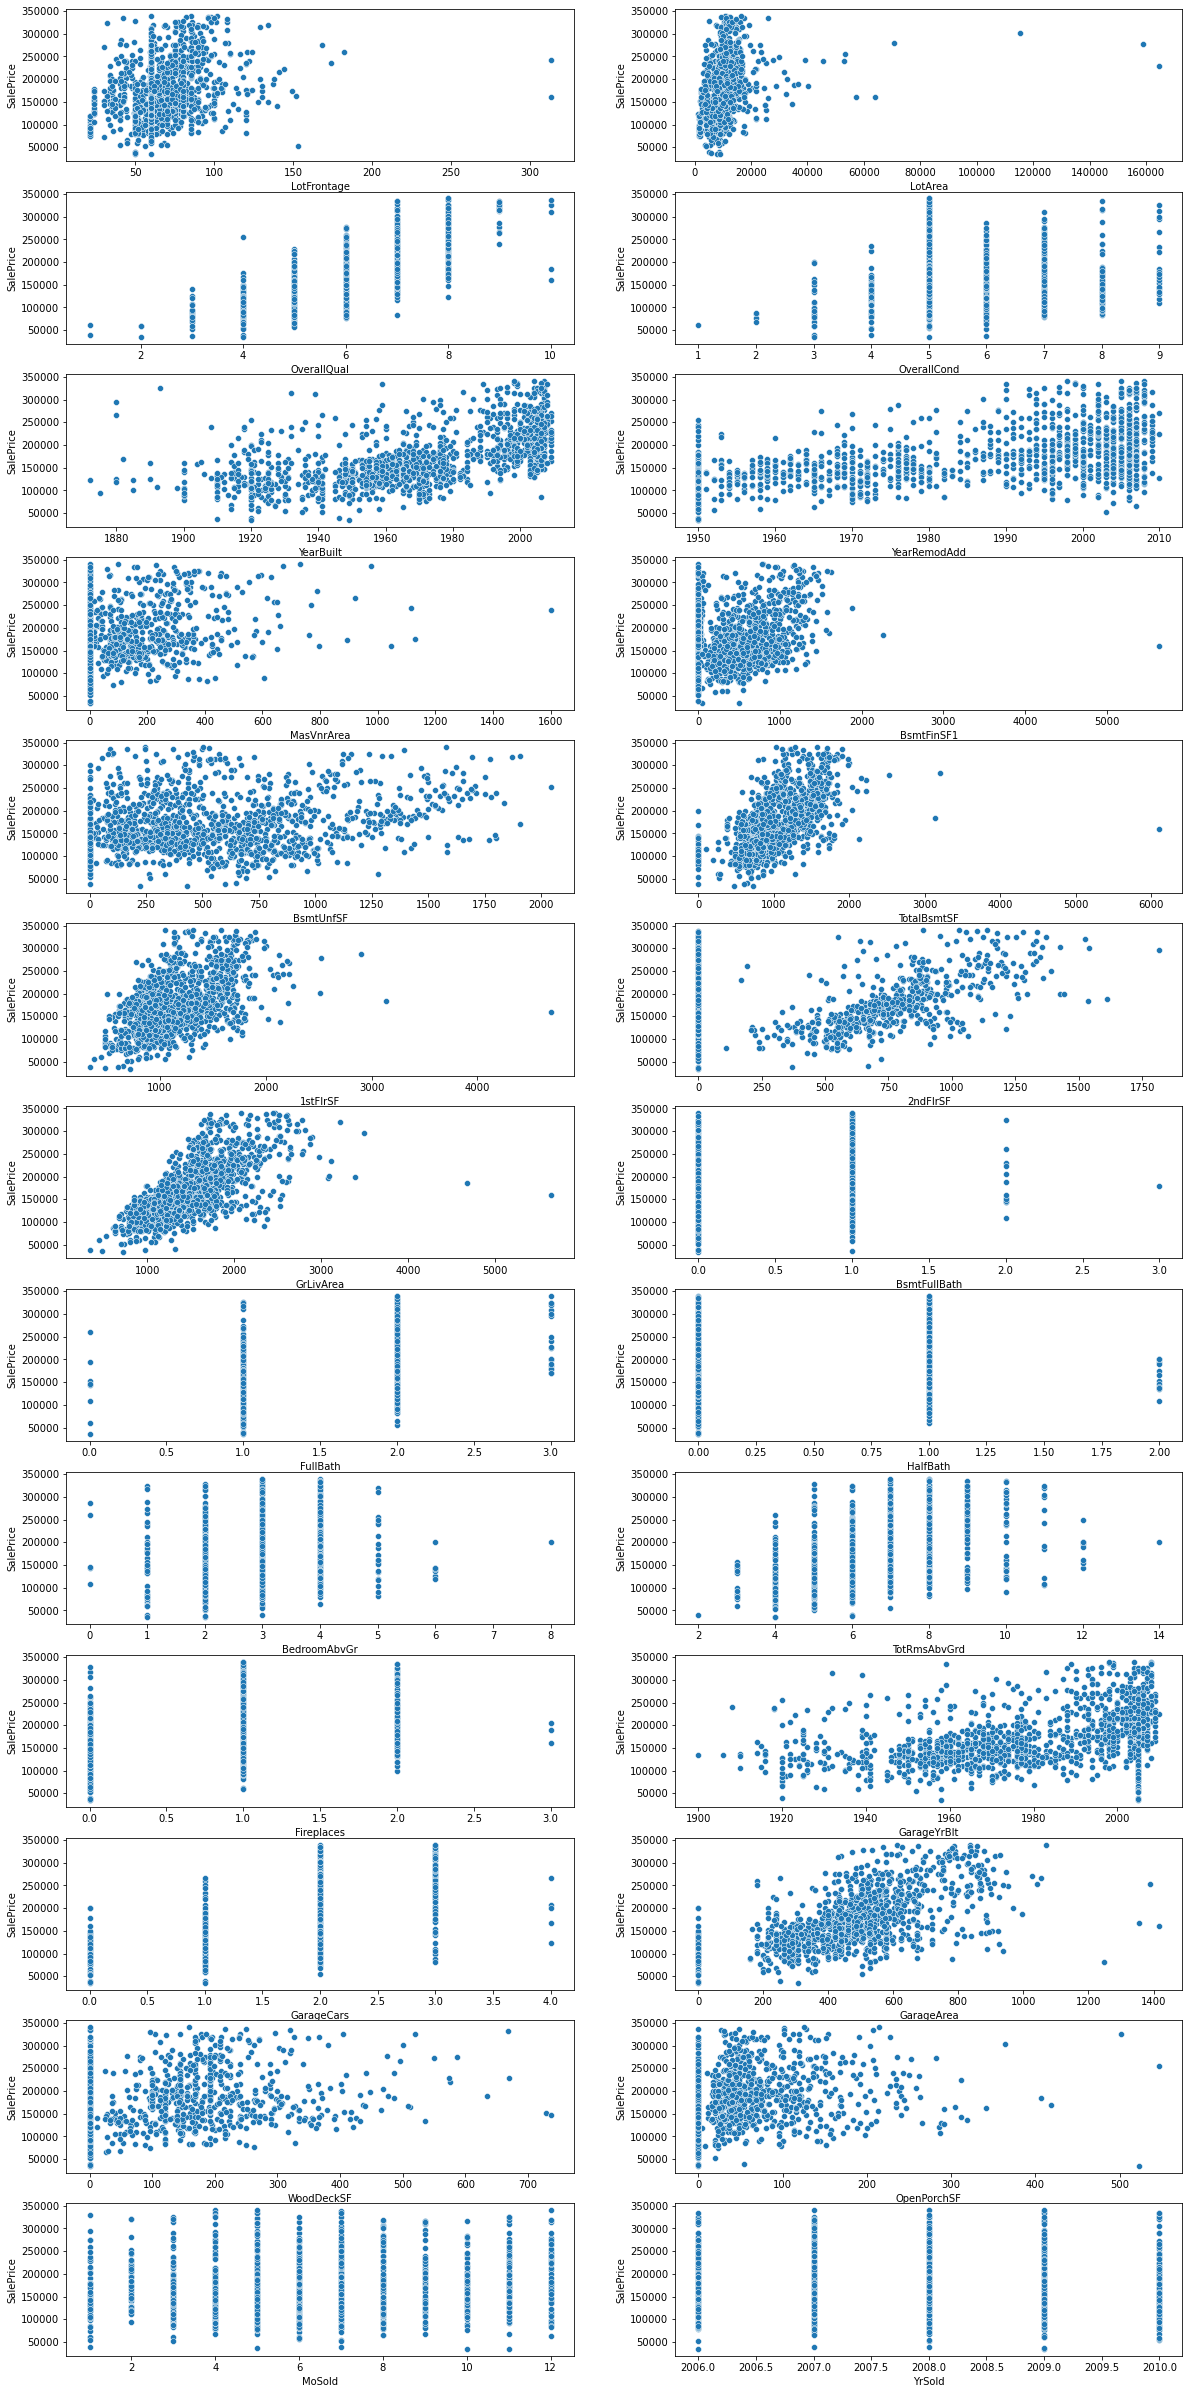

In [31]:
aux_num = numerical.drop(['Id'], axis = 1)

fig = plt.figure(figsize = (20, 60))
axis = fig.add_axes([0, 0, 1, 1])
x = 1

for column in aux_num:
    plt.subplot(18, 2, x)
    sns.scatterplot(data = aux_num, x = column, y = 'SalePrice')
    x += 1
    if x == aux_num.shape[1]:
        break

It is possible to notice that some attributes, even being int64 values, have categorical behavior (like 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'MoSold', 'YrSold', 'SalePrice').
Boxplot is the best plot for analisys in this situation.

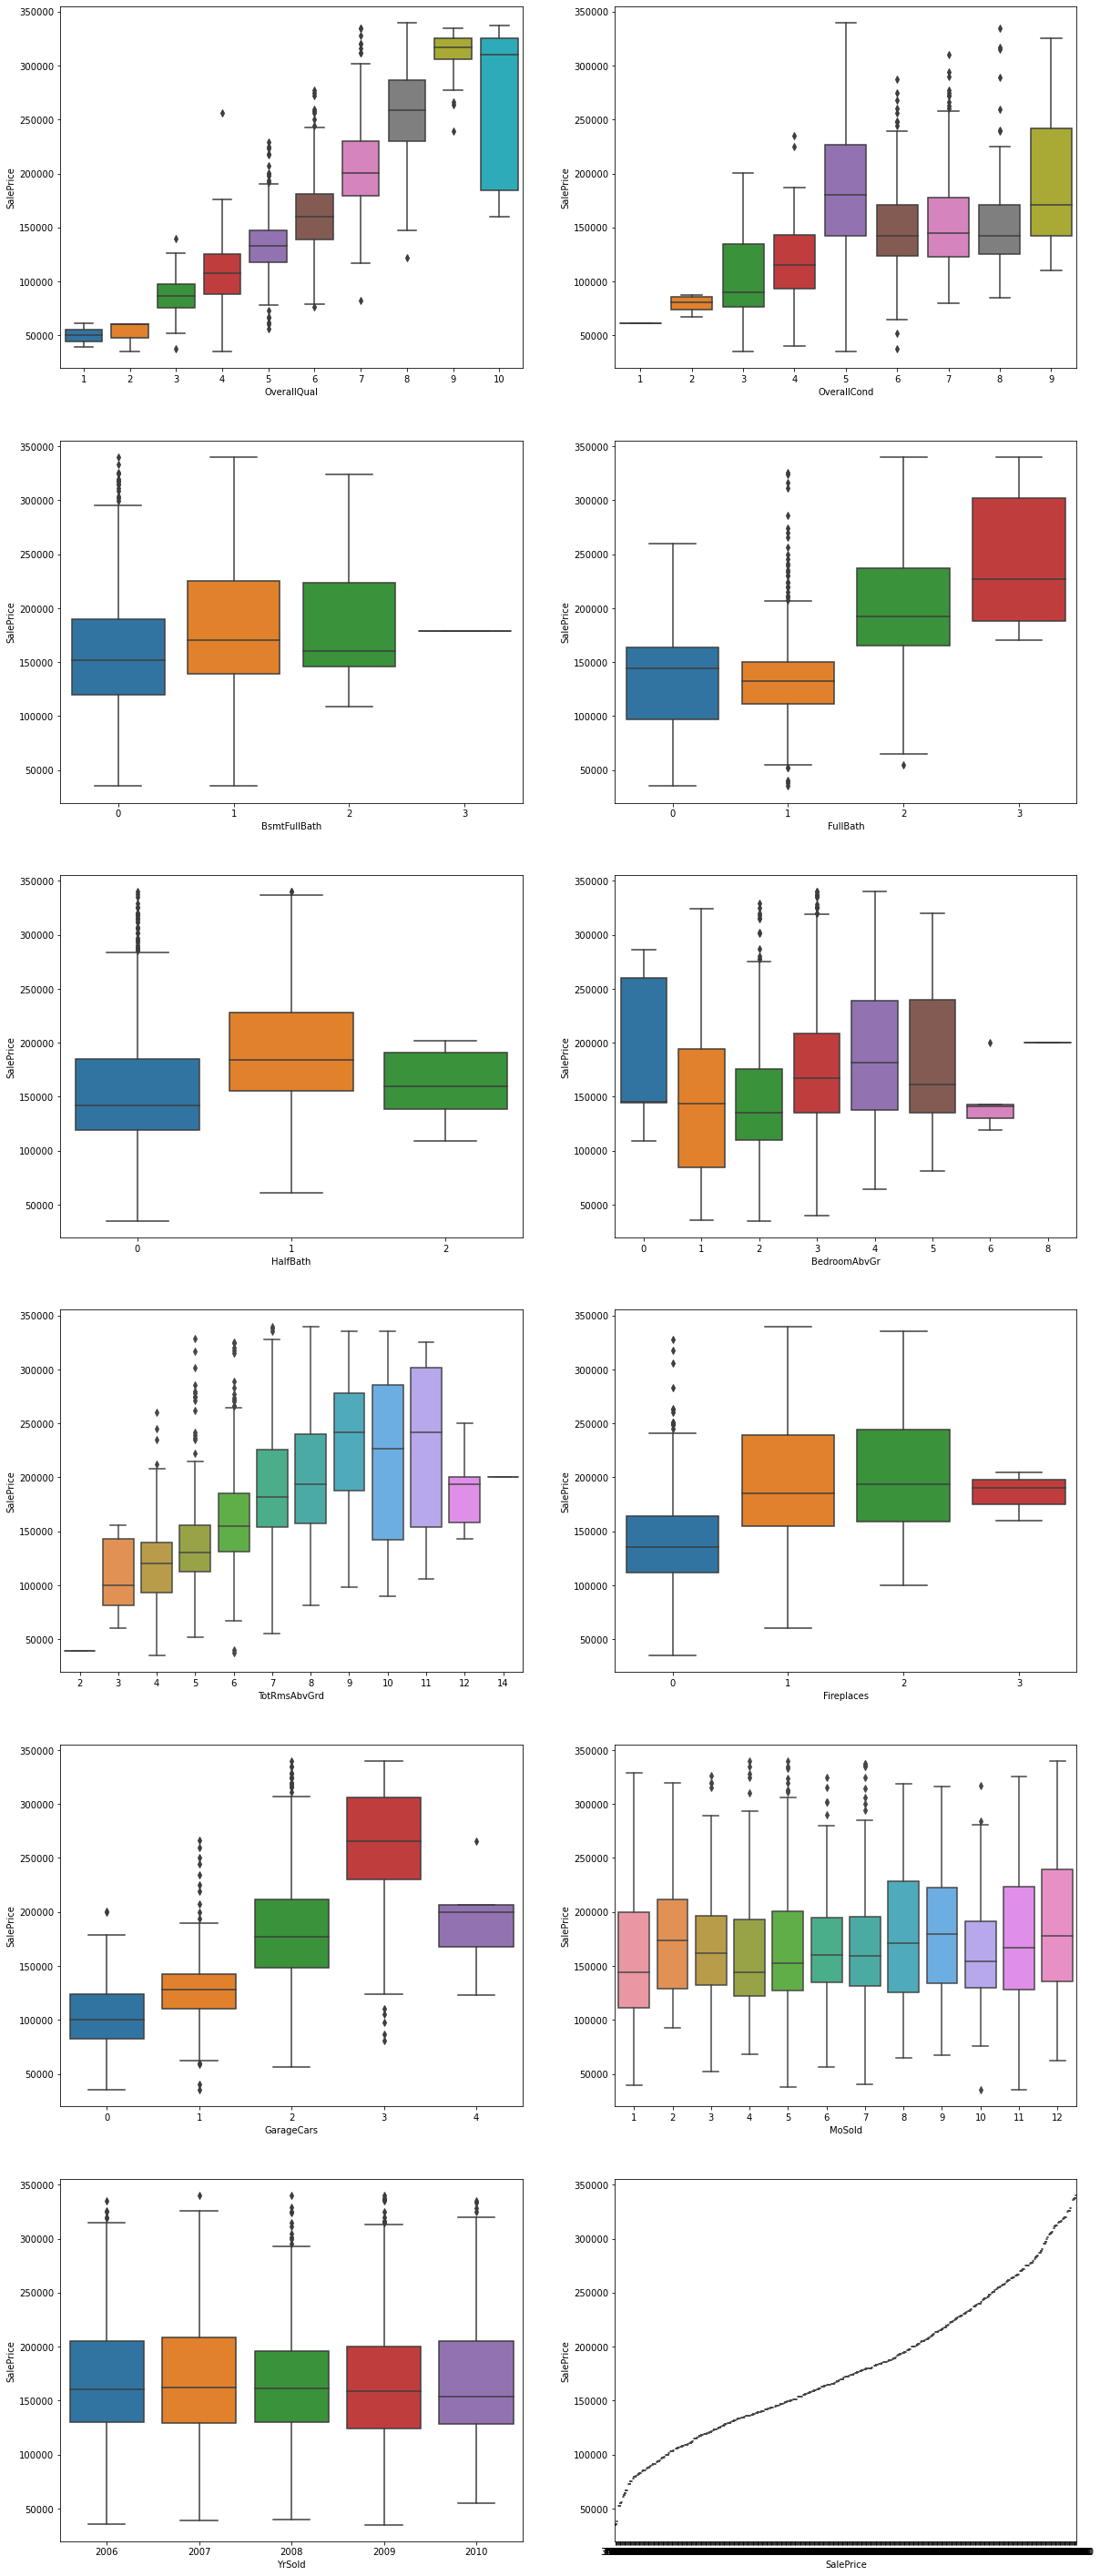

In [32]:
aux_num2 = numerical[['OverallQual', 'OverallCond', 'BsmtFullBath', 'FullBath', 'HalfBath', 
                      'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold', 'SalePrice']]

fig = plt.figure(figsize = (20, 60))
axis = fig.add_axes([0, 0, 1, 1])
x = 1

for column in aux_num2:
    plt.subplot(7, 2, x)
    sns.boxplot(data = aux_num2, x = column, y = 'SalePrice')
    x += 1

It is interesting to analyse that the attributes that were dropped before ('BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal') don't really contribute to the price change after data visualization, so, we can safety remove them and make the graphs again.

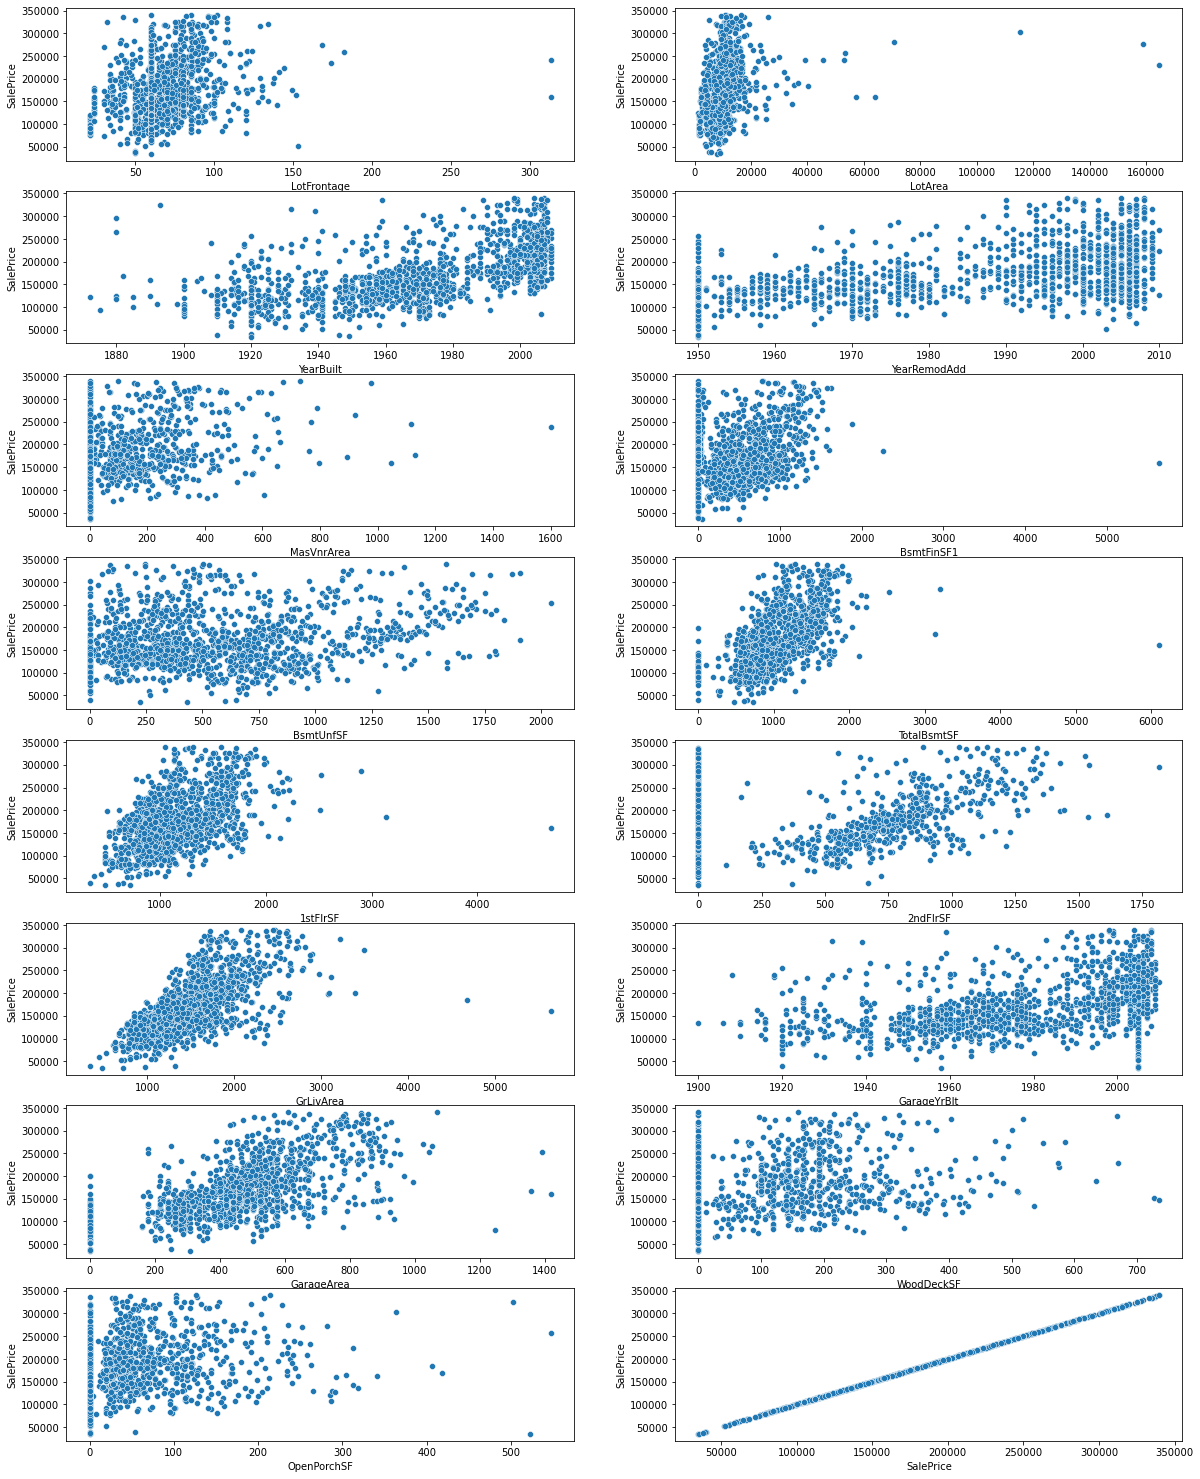

In [33]:
aux_num3 = aux_num
aux_num3 = aux_num3.drop(['OverallQual', 'OverallCond', 'BsmtFullBath', 'FullBath', 'HalfBath', 
                      'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold'], axis = 1)
fig = plt.figure(figsize = (20, 60))
axis = fig.add_axes([0, 0, 1, 1])
x = 1

for column in aux_num3:
    plt.subplot(18, 2, x)
    sns.scatterplot(data = aux_num3, x = column, y = 'SalePrice')
    x += 1
    if x == aux_num.shape[1]:
        break

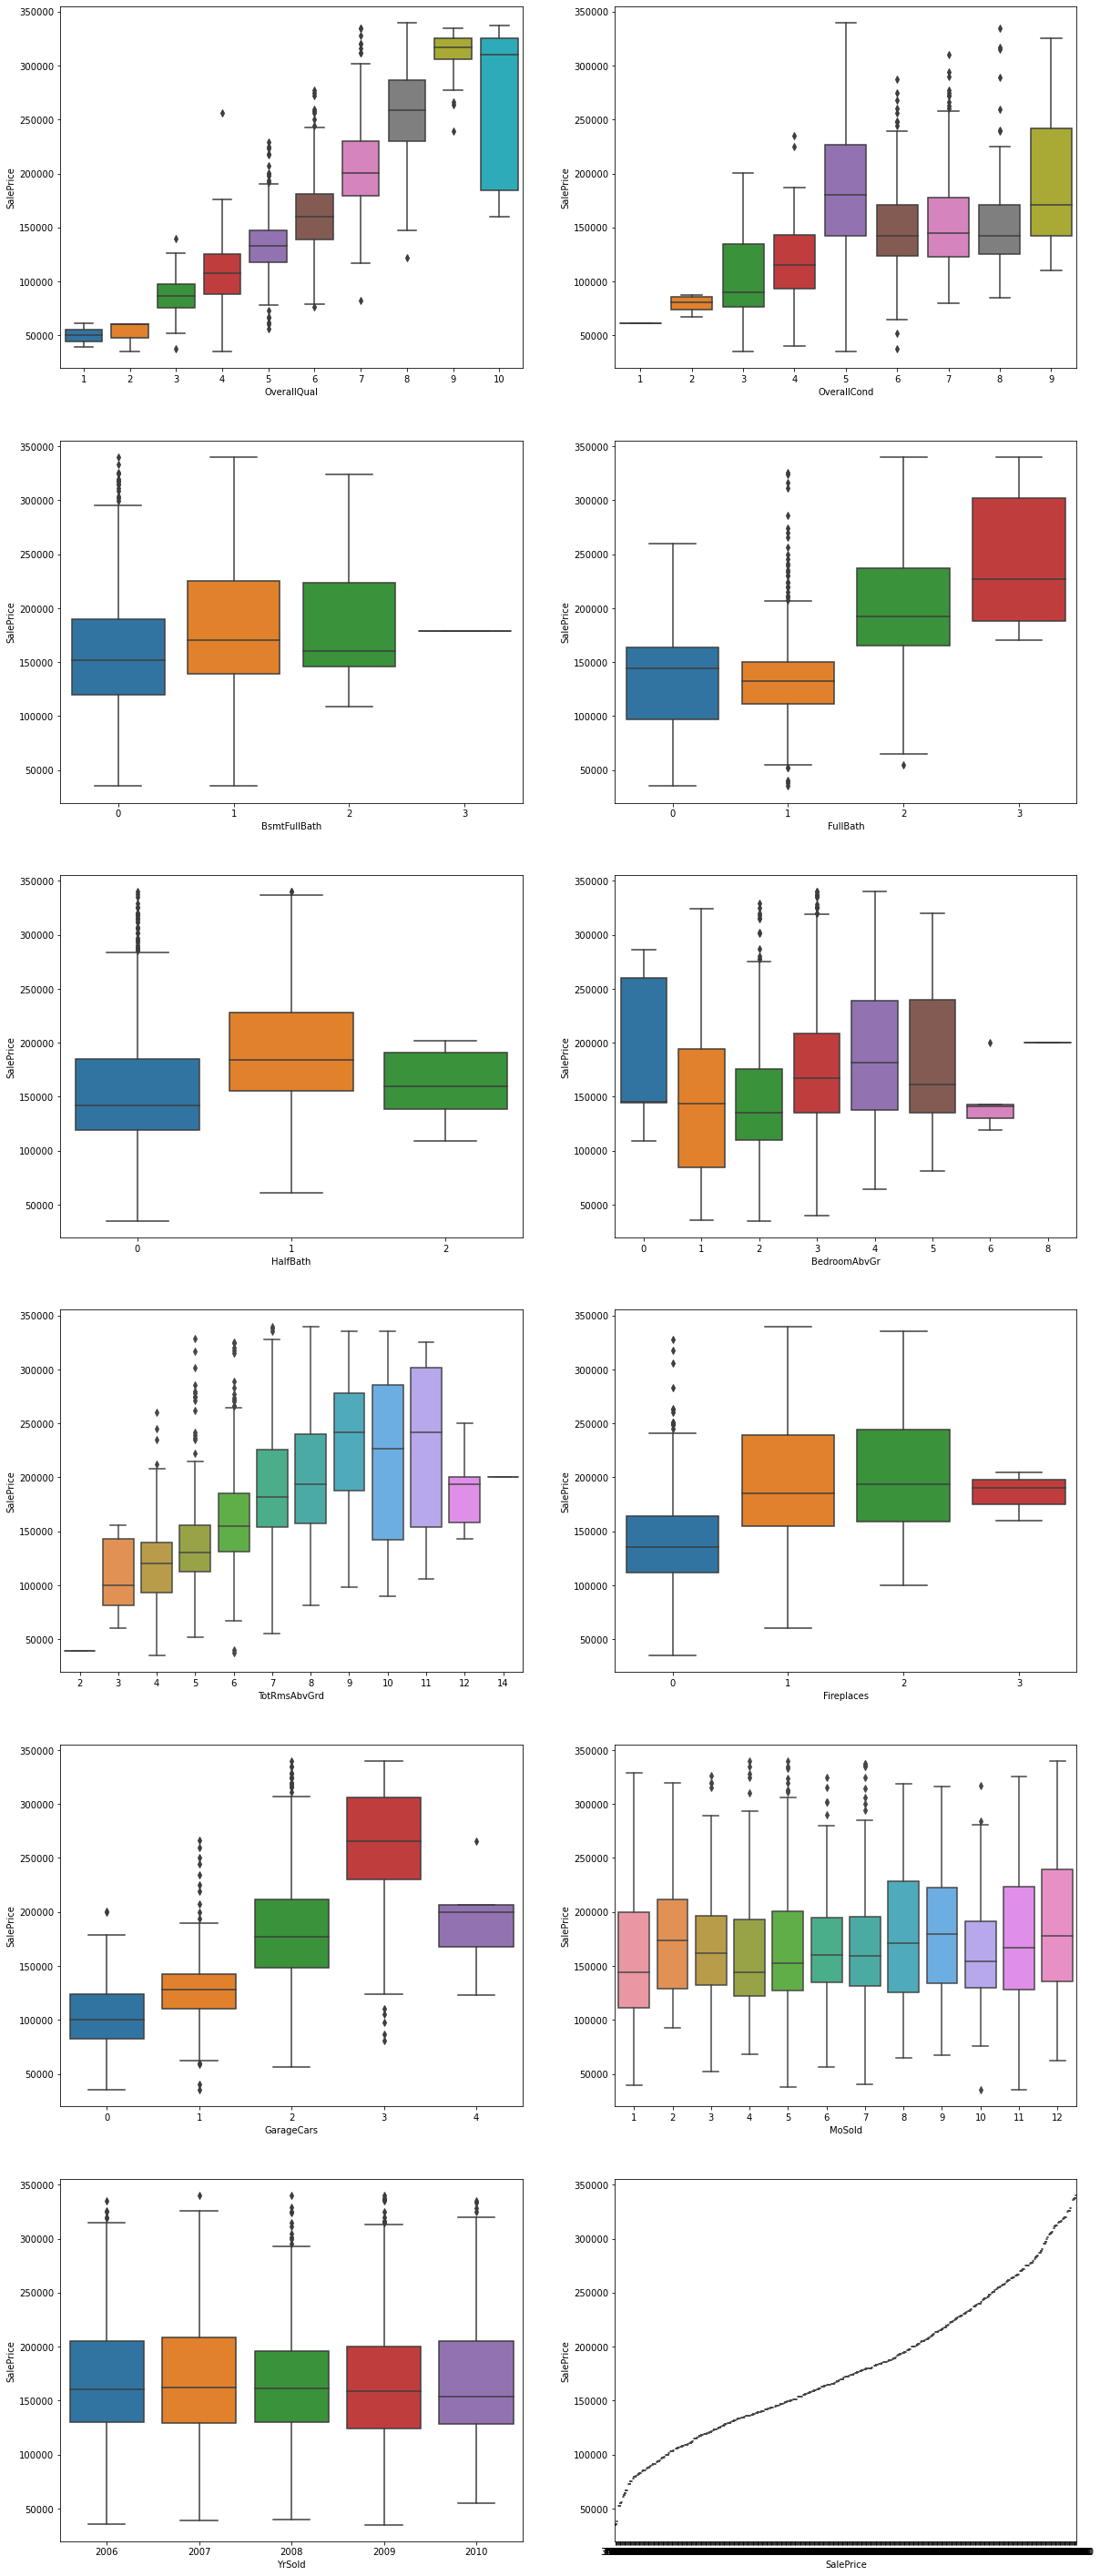

In [34]:
aux_num4 = numerical[['OverallQual', 'OverallCond', 'BsmtFullBath', 'FullBath', 'HalfBath', 
                      'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold', 'SalePrice']]

fig = plt.figure(figsize = (20, 60))
axis = fig.add_axes([0, 0, 1, 1])
x = 1

for column in aux_num4:
    plt.subplot(7, 2, x)
    sns.boxplot(data = aux_num4, x = column, y = 'SalePrice')
    x += 1

## Categorical Attributes

In this part I will plot boxplots for the categorical attributes. 

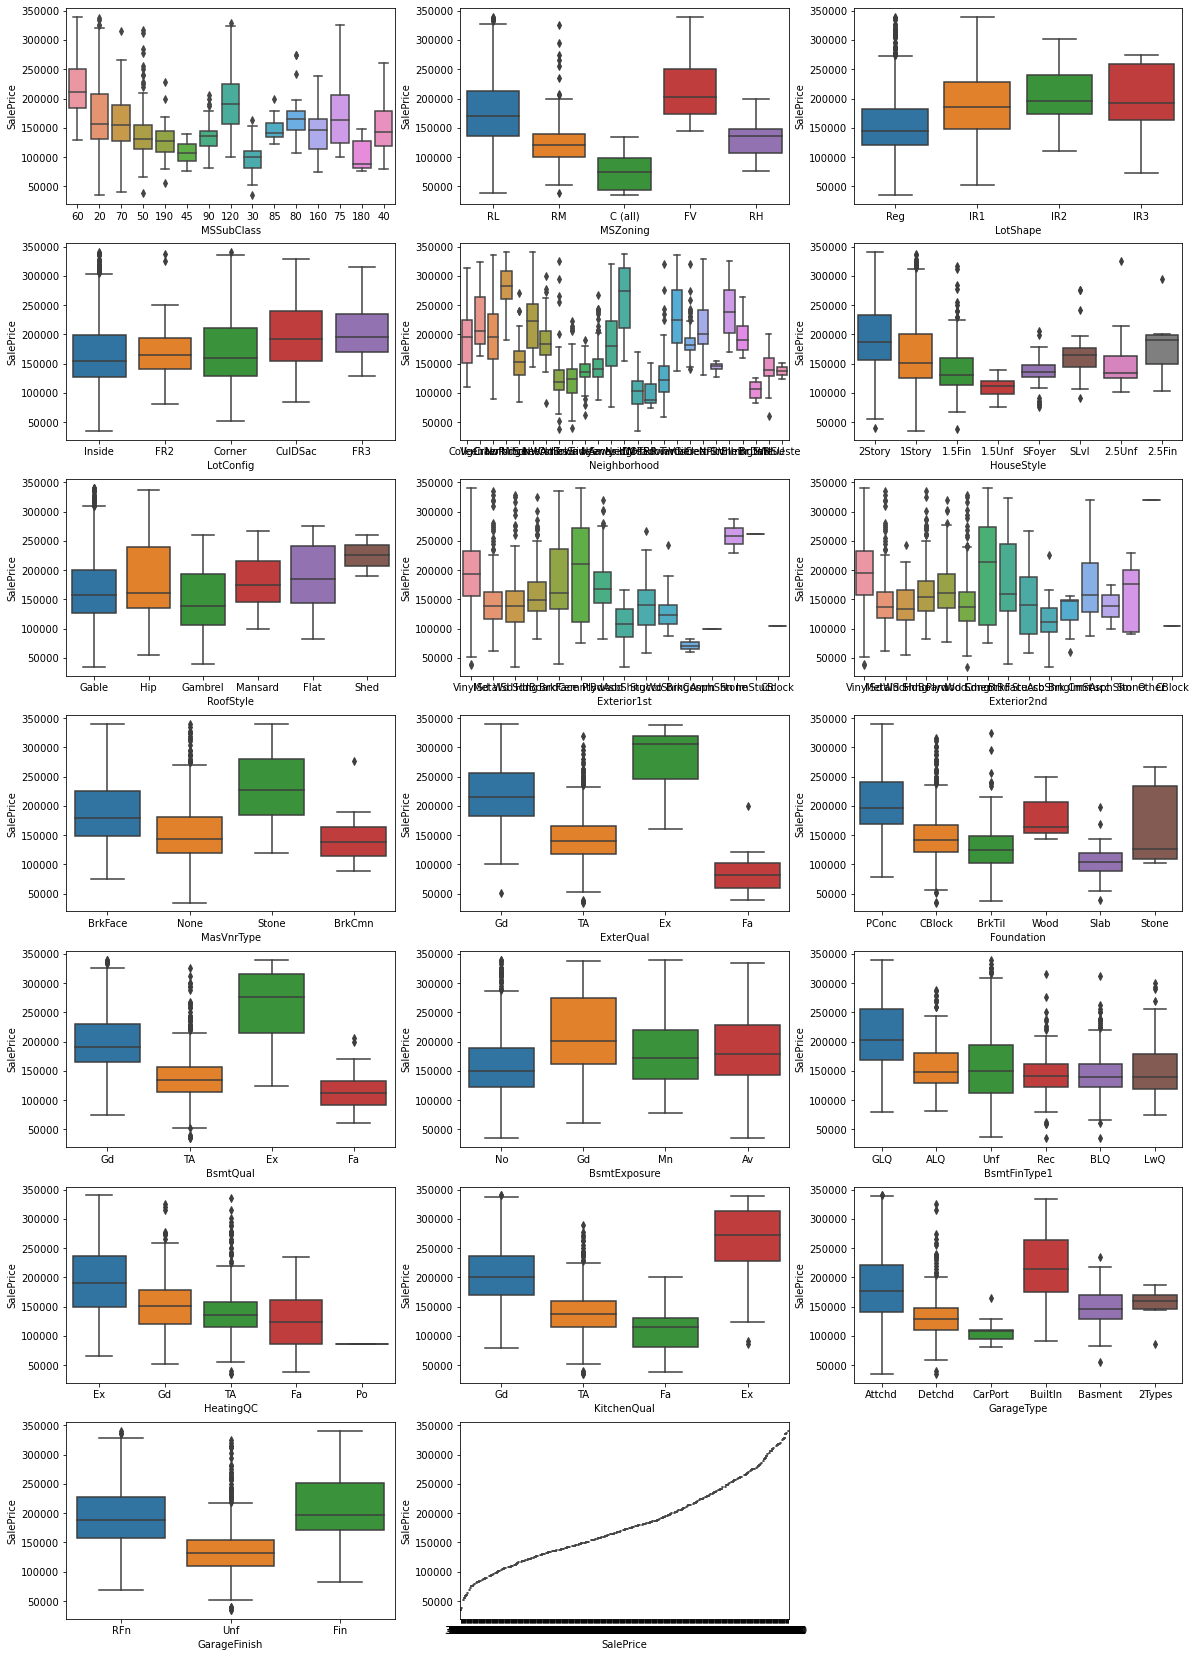

In [35]:
categorical = categorical.merge(numerical['SalePrice'], how = 'left', left_index=True, right_index=True)

fig = plt.figure(figsize = (20, 60))
axis = fig.add_axes([0, 0, 1, 1])
x = 1

for column in categorical:
    plt.subplot(14, 3, x)
    sns.boxplot(data = categorical, x = column, y = 'SalePrice')
    x += 1

#### observation

* for the scatterplot numerical attributes: some attributes, such as 'LotArea', '1stFlrSF' and 'GrLivArea' have a clear linear correlation with 'SlaesPrice'. But others, like 'TotalBsmtSF', '2ndFlrSF' and 'GarageArea', excluding x = 0, have almost a linear dependence.

* for the boxplot numerical attributes: it is clear that the higher the 'OverallQual', higher the price. Others attributes, like 'OverallCond', 'BsmtFullBath', 'BedroomAbvGr' and 'KitchenAbvGr' seems to have no influence in house prices. Time attribute like 'MoSold' and 'YrSold' also don't have any influence in price.

* for the boxplot categorical attributes: 'MSSubClass' and 'Neighborhood' make the price fluctuate considerably. While 'LotShape', 'LotConfig', 'BsmtFinType1', 'BsmtExposure' and 'HeatingQC' have no or very little influence in price behavior.
    
With the graphs made, we can now make some hypotesis.

## Hypotesis

Let's make some hypotesis:
* Year based:

    1 - New houses cost more
    
    2 - remodeled houses cost more
    
    3 - New houses have higher quality and cost more
    
    4 - Remodeled houses have higher quality and condition cost more
    
    
* Quality based:

    1 - Higher the quality, higher the price
    
    2 - higher the condition, higher the price
    

* Garage based:

    1 - The type of garage has influence in the price
    
    2 - houses without car space cost less
    
    3 - houses with more capacity (number of cars) have larger garage area and cost more.
    

* House rooms based:

    1 - houses with more bedrooms cost more
    
    2 - houses with full bath + half bath cost more
    
    3 - houses with larger GrLivArea cost more
    
    4 - houses with more kitchen cost more
    
    5 - houses with better kitchen quality cost more
    
    
* Outside house based:

    1 - the neighborhood has influence in price
    
    2 - the lot configuration has influence in price
    
    3 - lot shape has influence in price
    
    4 - more than one frontage makes the price increase
    

To help me not forget of any attribute, I will create a dataframe called 'to_analyse' with the same columns of our principal dataframe. After using the variables to confirm or not our hypotesis, I will drop the used columns.

In [36]:
to_analyse = data.copy()
to_analyse.drop('Id', axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [37]:
data1 = data[['SalePrice', 'YearBuilt']].groupby('YearBuilt').mean().reset_index()
data1.head()

,YearBuilt,SalePrice
0,1872,122000.00
1,1875,94000.00
2,1880,200619.75
3,1882,168000.00
4,1885,111250.00


### Year based Hypotesis
#### 1 - New houses cost more

For evaluete this hypotesis, I will plot a linearplot showing the mean of house prices by the year of built.

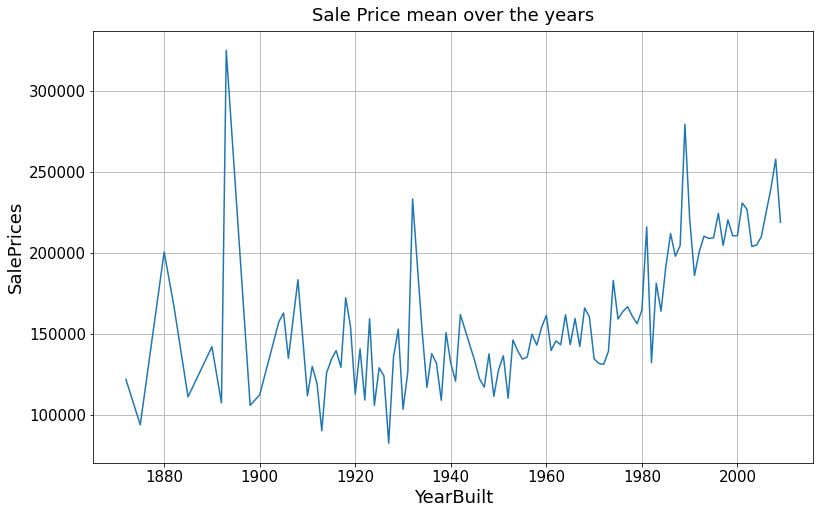

In [38]:
fig = plt.figure(figsize = (10, 6))
axis = fig.add_axes([0, 0, 1, 1])
sns.lineplot(data = data1, x = 'YearBuilt', y = 'SalePrice')
axis.set_title('Sale Price mean over the years', fontsize = 18, pad = 10)
axis.set_xlabel('YearBuilt', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True)


Although the graph shows a positive slope after 1960, I don't think that we can definitely say that new houses cost more. The mean in the years close to 1890 is almost the same as 2000. 

I belive that the tendecy is that, in the future, new houses will cost more, but, based in what our dataset shows, we can't say for sure. That said, I think it is not a relevant variable for us to use in our model.

In [39]:
to_analyse.drop('YearBuilt', axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### 2 - Remodeled houses cost more

In [40]:
data2 = data[['SalePrice', 'YearBuilt', 'YearRemodAdd']].copy()
data2['WasRemod'] = data2[['YearBuilt', 'YearRemodAdd']].apply(lambda x: 0 if x['YearRemodAdd'] - x['YearBuilt'] == 0
                                                           else 1, axis = 1)
data2 = data2.groupby('WasRemod').mean().reset_index()
data2


,WasRemod,SalePrice,YearBuilt,YearRemodAdd
0,0,174916.298649,1982.545946,1982.545946
1,1,164982.822458,1956.083460,1985.757208


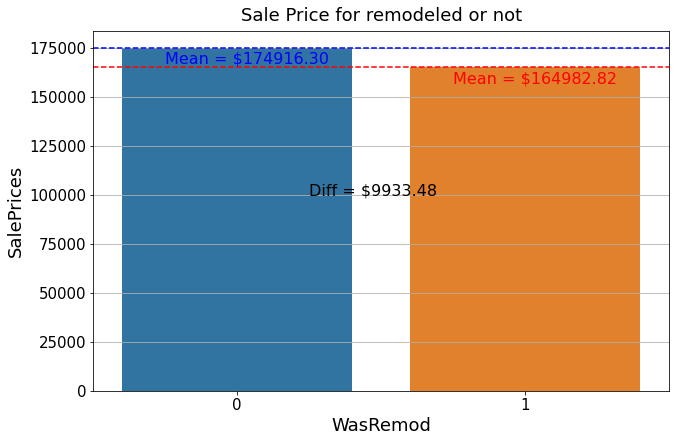

In [41]:
fig = plt.figure(figsize = (8, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.barplot(data = data2, x = 'WasRemod', y = 'SalePrice')
axis.set_title('Sale Price for remodeled or not', fontsize = 18, pad = 10)
axis.set_xlabel('WasRemod', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

axis.axhline(y = data2.loc[0, 'SalePrice'], color = 'blue', linestyle = '--');
axis.annotate('Mean = ${:.2f}'.format(data2.loc[0, 'SalePrice']), xy = (-0.25, data2['SalePrice'].mean() - 3000), fontsize = 16, color = 'blue')
axis.axhline(y = data2.loc[1, 'SalePrice'], color = 'red', linestyle = '--');
axis.annotate('Mean = ${:.2f}'.format(data2.loc[1, 'SalePrice']), xy = (0.75, data2.loc[1, 'SalePrice'] - 8000), fontsize = 16, color = 'red')
axis.annotate('Diff = ${:.2f}'.format(data2.loc[0, 'SalePrice'] - data2.loc[1, 'SalePrice']), xy = (0.25, 100000), fontsize = 16, color = 'black')
plt.show()

After analyzing the graph and the mean values, we can say for sure that remodeled houses don't cost more. Then, we conclude that this variable is not relevant for our final model!

In [42]:
to_analyse.drop('YearRemodAdd', axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### 3 - New houses have higher quality and condition cost more

From data text description, we have:

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent       
       9	Excellent       
       8	Very Good       
       7	Good       
       6	Above Average       
       5	Average       
       4	Below Average       
       3	Fair       
       2	Poor       
       1	Very Poor
       
OverallCond follows the same table.
Let's first analyse the overal quality. We can use data3, created bellow, and make a boxplot, using 'hue' = 'WasRemod'.

In [43]:
data3 = data[['SalePrice', 'YearBuilt', 'YearRemodAdd', 'OverallQual', 'OverallCond']].copy()
data3['WasRemod'] = data3[['YearBuilt', 'YearRemodAdd']].apply(lambda x: 0 if x['YearRemodAdd'] - x['YearBuilt'] == 0
                                                           else 1, axis = 1)
data3.head()

,SalePrice,YearBuilt,YearRemodAdd,OverallQual,OverallCond,WasRemod
0,208500,2003,2003,7,5,0
1,181500,1976,1976,6,8,0
2,223500,2001,2002,7,5,1
3,140000,1915,1970,7,5,1
4,250000,2000,2000,8,5,0


In [44]:
data4 = data3.groupby('YearBuilt').mean().reset_index()
data4.head()

,YearBuilt,SalePrice,YearRemodAdd,OverallQual,OverallCond,WasRemod
0,1872,122000.00,1987.0,8.00,5.0,1.0
1,1875,94000.00,1996.0,5.00,8.0,1.0
2,1880,200619.75,1986.5,6.25,6.5,1.0
3,1882,168000.00,1986.0,8.00,9.0,1.0
4,1885,111250.00,1972.5,4.00,6.5,1.0


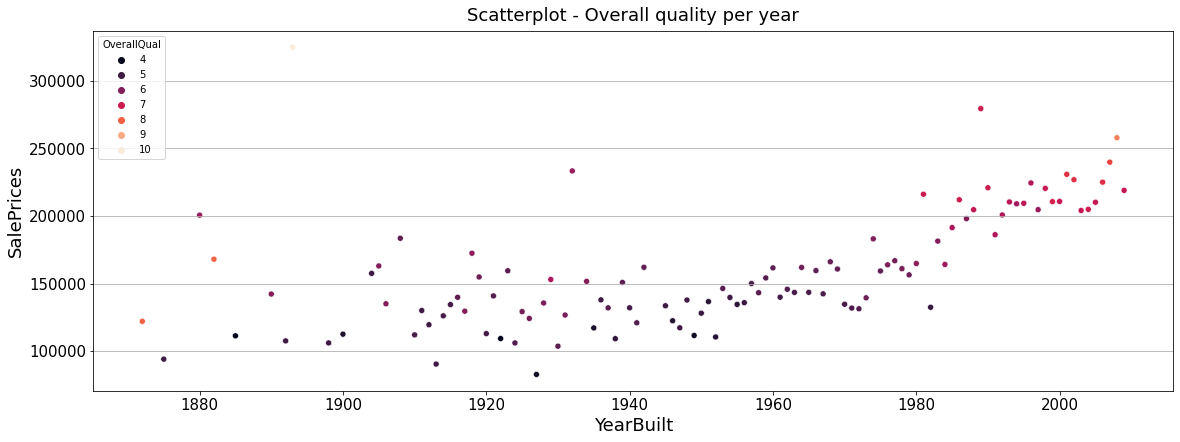

In [45]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.scatterplot(data = data4, x = 'YearBuilt', y = 'SalePrice', hue = 'OverallQual', palette = 'rocket')
axis.set_title('Scatterplot - Overall quality per year', fontsize = 18, pad = 10)
axis.set_xlabel('YearBuilt', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

This hipotesys seems to be true, it is possible to note that for houses above 1990 the grades are 7 - 10, while for years under 1990, the grades are lower. Then, I believe this is an important variable to be considered.

In [46]:
to_analyse.drop(['OverallQual', 'OverallCond'], axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### 4 - Remodeled houses have higher quality and condition cost more

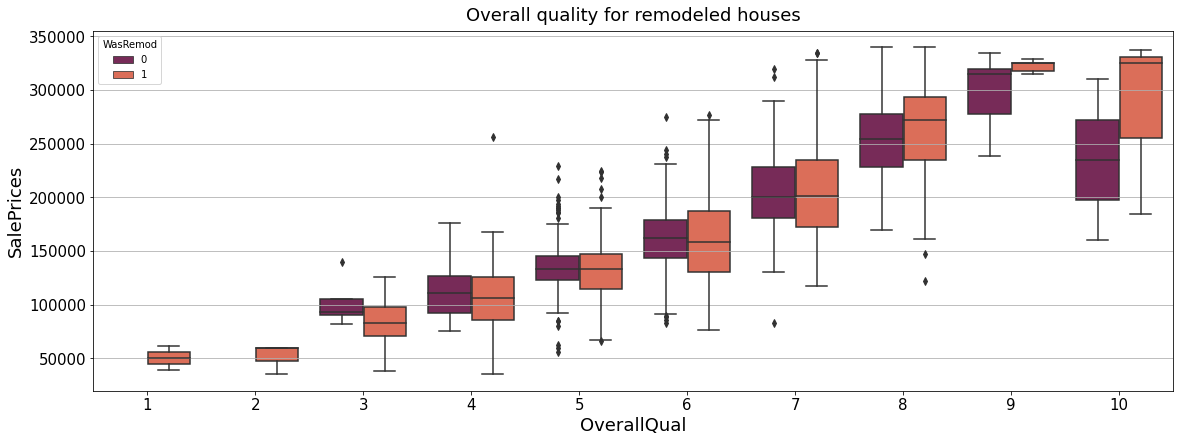

In [47]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data3, x = 'OverallQual', y = 'SalePrice', hue = 'WasRemod', palette = 'rocket')
axis.set_title('Overall quality for remodeled houses', fontsize = 18, pad = 10)
axis.set_xlabel('OverallQual', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

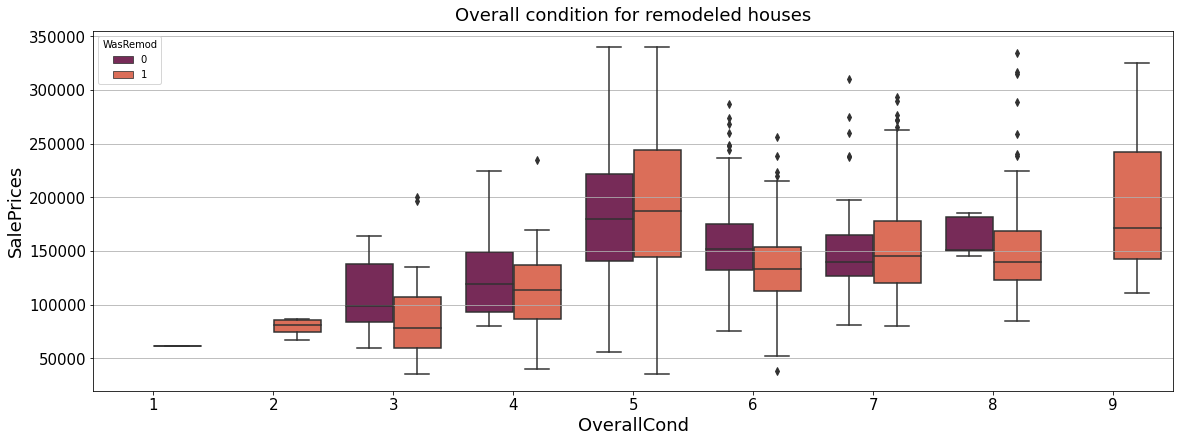

In [48]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data3, x = 'OverallCond', y = 'SalePrice', hue = 'WasRemod', palette = 'rocket')
axis.set_title('Overall condition for remodeled houses', fontsize = 18, pad = 10)
axis.set_xlabel('OverallCond', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')


It is an interesting result, we can notice that both OveralQual and OveralCond has some little differences, but, don't seem to be an important variable. Thus, we can say that remodeled houses don't have different SalePrice than not remodeled.

### Quality based:

#### 1 - Higher the quality, higher the price

#### 2 - higher the condition, higher the price

Both questions can be answered by the two last graphs. 

Graph SalesPrice vs OverallQual shows that remodeled and non remodeled houses have almost the same prices, but, houses with higher overal quality tends to have higher sale price.

However, this relation isn't so clear for SalesPrice vs OveralCond. We can see that there is a variation, but it is not enough to prove that thare is a relation.

In conclusion, overall quality is an important variable for house prices and should be included in final model, while overal condition should not.

### Garage based:

#### 1 - The type of garage has influence in the price

From the description, we have:
    
    GarageType: Garage location

       2Types   More than one type of garage
       Attchd   Attached to home
       Basment  Basement Garage
       BuiltIn  Built-In (Garage part of house - typically has room above garage)
       CarPort  Car Port
       Detchd   Detached from home
       NA   No Garage


In [49]:
data5 = data[['SalePrice', 'GarageType']]
data5.head()


,SalePrice,GarageType
0,208500,Attchd
1,181500,Attchd
2,223500,Attchd
3,140000,Detchd
4,250000,Attchd


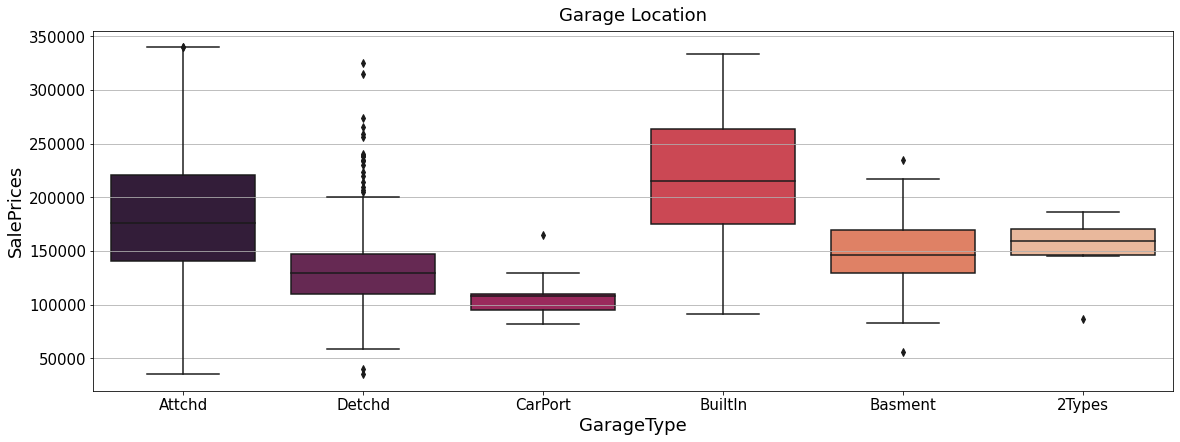

In [50]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data5, x = 'GarageType', y = 'SalePrice',  palette = 'rocket')
axis.set_title('Garage Location', fontsize = 18, pad = 10)
axis.set_xlabel('GarageType', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')


It is possible to see that houses with 2 types don't cost more than the others. The higher price comes with the builtin type and the lower is for CarPort

#### 2 - houses without car space cost less and with more car space cost more
$\textbf{and}$                              
#### 3 - houses with Finished garage and more car space cost more.

From the description, we have that:

    GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [51]:
data6 = data[['SalePrice', 'GarageFinish', 'GarageCars']].copy()
data6.head()

,SalePrice,GarageFinish,GarageCars
0,208500,RFn,2
1,181500,RFn,2
2,223500,RFn,2
3,140000,Unf,3
4,250000,RFn,3


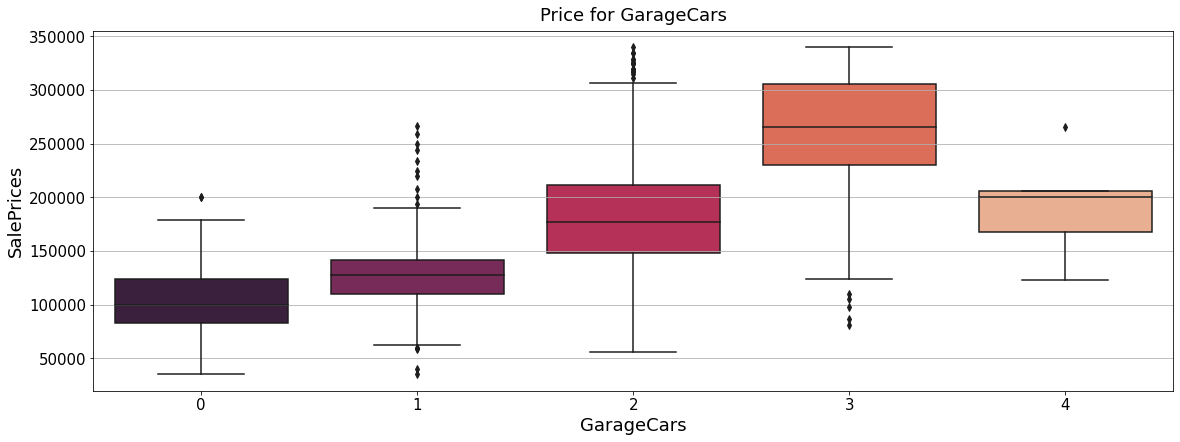

In [52]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data6, x = 'GarageCars', y = 'SalePrice',  palette = 'rocket')
axis.set_title('Price for GarageCars', fontsize = 18, pad = 10)
axis.set_xlabel('GarageCars', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

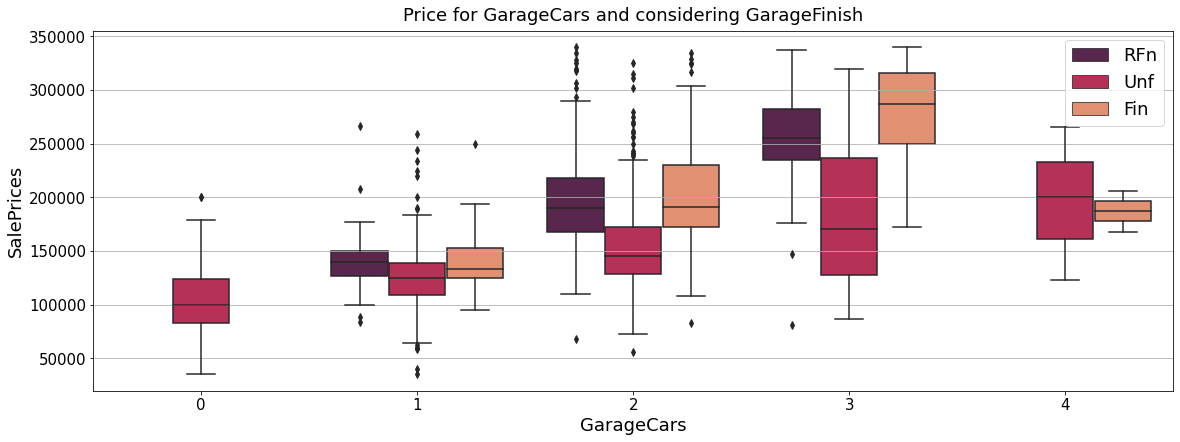

In [53]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data6, x = 'GarageCars', y = 'SalePrice', hue = 'GarageFinish', palette = 'rocket')
axis.set_title('Price for GarageCars and considering GarageFinish', fontsize = 18, pad = 10)
axis.set_xlabel('GarageCars', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')
plt.legend(fontsize = 18);

We can see that it follows the same behavir analysed in the last topic. There are a responsive difference between the amount of cars in garage, it increases until 3 garage cars, but it goes down for 4 cars. Houses with unfinished garage have lower prices and with finished garage tends to have higher price.

I belive that GarageCars is an important variable for house price, but not by itself.


In [54]:
to_analyse.drop(['GarageCars', 'GarageFinish', 'GarageType'], axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

### House rooms based:

#### 1 - houses with more bedrooms cost more

I will create a dataframe including 'SalePrice', 'BedroomAbvGr', 'TotRmsAbvGrd', ans a new column that will calculate the number of rooms excluding the numer of bedrooms, that way, we can see the influence of the number of bedrooms in the price.

In [55]:
data7 = data[['SalePrice', 'BedroomAbvGr', 'TotRmsAbvGrd']].copy()
data7['tot_rooms_no_bedrooms'] = data7['TotRmsAbvGrd'] - data7['BedroomAbvGr']
data7.head()

,SalePrice,BedroomAbvGr,TotRmsAbvGrd,tot_rooms_no_bedrooms
0,208500,3,8,5
1,181500,3,6,3
2,223500,3,6,3
3,140000,3,7,4
4,250000,4,9,5


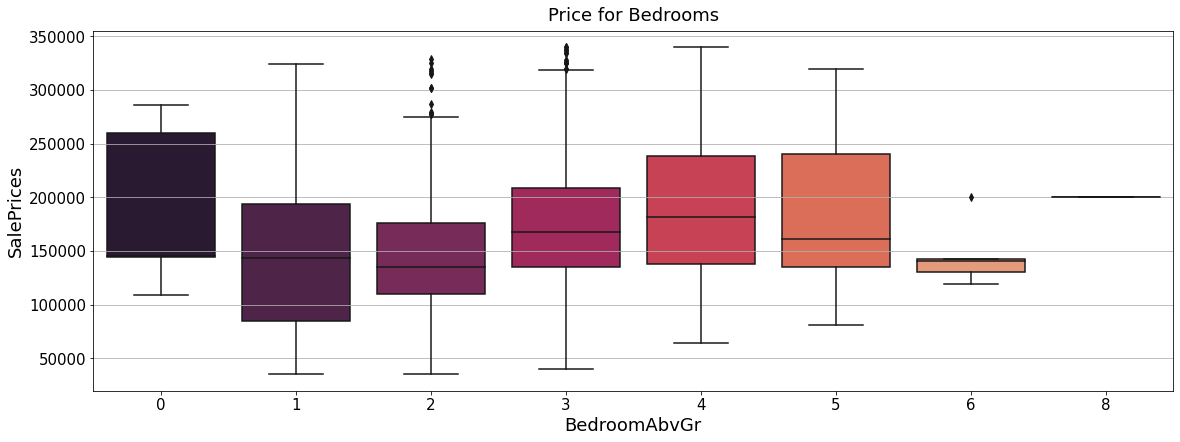

In [56]:
# creating the graph for price x number of bedrooms

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data7, x = 'BedroomAbvGr', y = 'SalePrice', palette = 'rocket')
axis.set_title('Price for Bedrooms', fontsize = 18, pad = 10)
axis.set_xlabel('BedroomAbvGr', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')


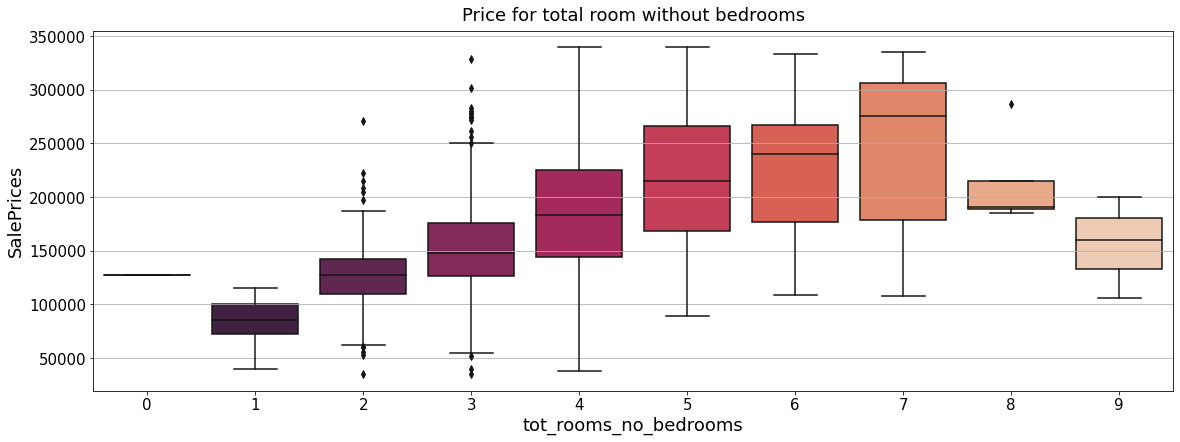

In [57]:
# creating the graph for price x number of rooms excluding bedrooms

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data7, x = 'tot_rooms_no_bedrooms', y = 'SalePrice', palette = 'rocket')
axis.set_title('Price for total room without bedrooms', fontsize = 18, pad = 10)
axis.set_xlabel('tot_rooms_no_bedrooms', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')


This are interesting results. The number of bedrooms doesn't seem to influence in the sale price of the house since we have a house with 8 bedrooms costing almost the same of a house with no bedrooms. However, the total number of rooms (excluding bedrooms) seems to have an influence over the price, the value groes up until 7 rooms and decrease for 8 and 9 rooms.
Thus, I think it is an important variable for the model.

In [58]:
data['tot_rooms_no_bedrooms'] = data7['tot_rooms_no_bedrooms']
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice,tot_rooms_no_bedrooms
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,...,2003.0,RFn,2,548,0,61,2,2008,208500,5
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,...,1976.0,RFn,2,460,298,0,5,2007,181500,3
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,...,2001.0,RFn,2,608,0,42,9,2008,223500,3
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,...,1998.0,Unf,3,642,0,35,2,2006,140000,4
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,...,2000.0,RFn,3,836,192,84,12,2008,250000,5


In [59]:
to_analyse.drop(['BedroomAbvGr', 'TotRmsAbvGrd'], axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenQual', 'Fireplaces',
       'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

#### 2 - houses with full bath + half bath cost more

To analyse this proposition, I will create a dataframe with 'FullBath', 'HalfBath', 'BsmtFullBath', I will create a new column called 'total_bath', that is the sum of 'FullBath', 'HalfBath', then, I will create another column named 'total_bath_with_bsm', that is basiclly the sum of 'total_bath' and basement full bath, i.e., 'BsmtFullBath'.


In [60]:
data9 = data[['FullBath', 'HalfBath', 'BsmtFullBath']].copy()
data9['total_bath'] = data9['FullBath'] + data9['HalfBath']
data9['total_bath_with_bsm'] = data9['total_bath'] + data9['BsmtFullBath']
data9['SalePrice'] = data['SalePrice']
data9.head()

,FullBath,HalfBath,BsmtFullBath,total_bath,total_bath_with_bsm,SalePrice
0,2,1,1,3,4,208500
1,2,0,0,2,2,181500
2,2,1,1,3,4,223500
3,1,0,1,1,2,140000
4,2,1,1,3,4,250000


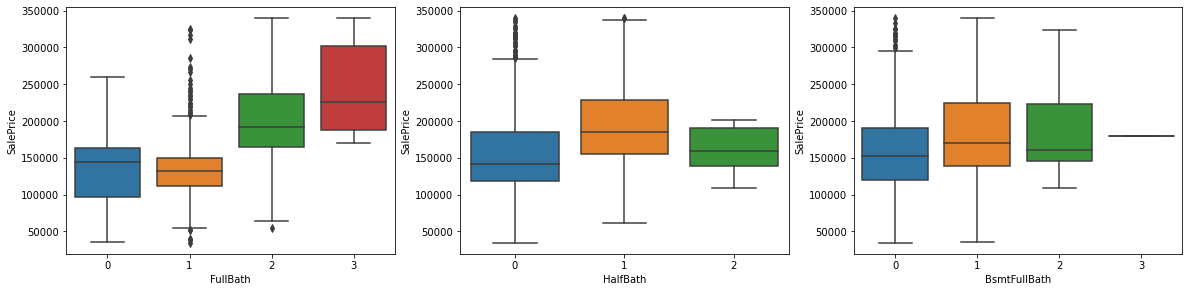

In [61]:
fig = plt.figure(figsize = (20, 10))
axis = fig.add_axes([0, 0, 1, 1])
x = 1

for column in data9:
        
    plt.subplot(2, 3, x)
    sns.boxplot(data = data9, x = column, y = 'SalePrice')
    x += 1
    if x == 4:
        break

First, I will analyse the impact of each bath type ('FullBath', 'HalfBath', 'BsmtFullBath') in the price. We can see that the only attribute that really applies an influence over price is 'FullBath'. 'HalfBath', 'BsmtFullBath', isolated, seem to have no influence under the price, since median variance is low.

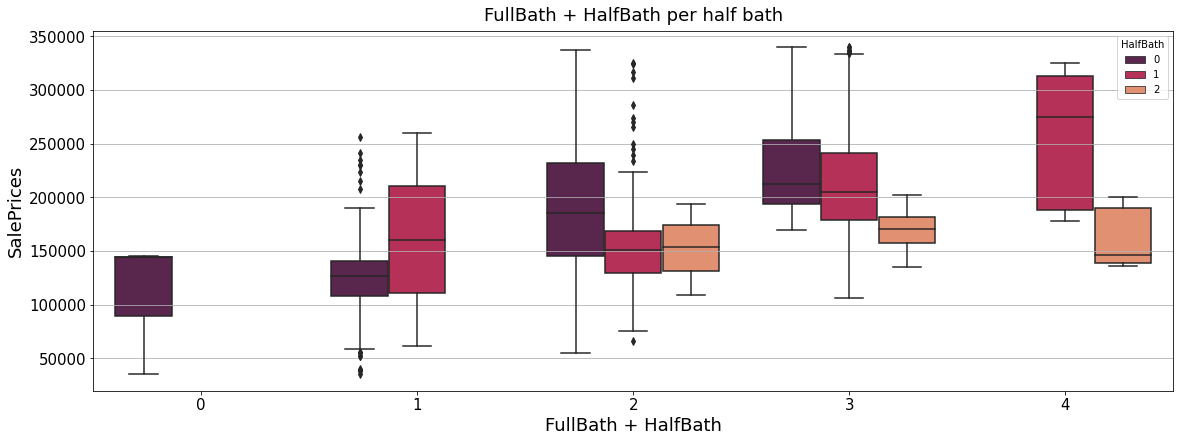

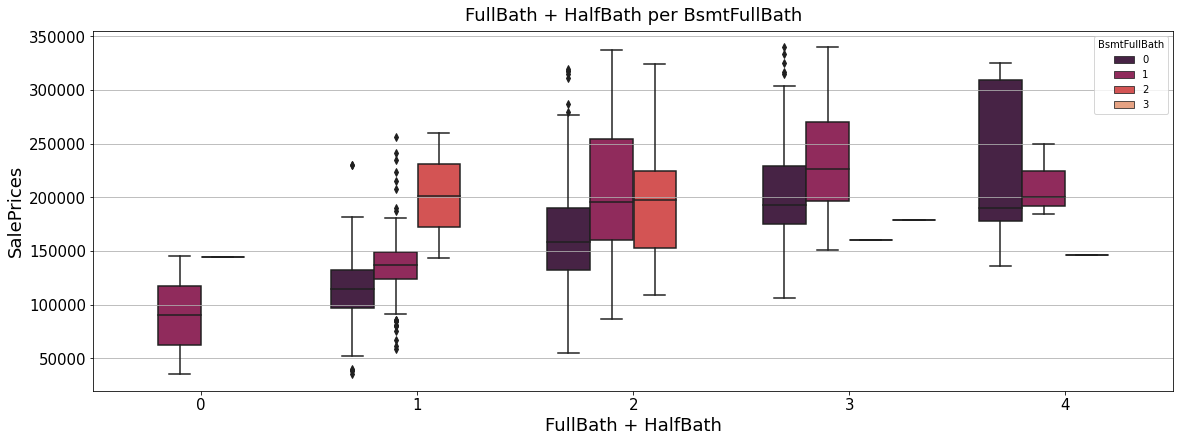

In [62]:

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data9, x = 'total_bath', y = 'SalePrice', hue = 'HalfBath', palette = 'rocket')
axis.set_title('FullBath + HalfBath per half bath', fontsize = 18, pad = 10)
axis.set_xlabel('FullBath + HalfBath', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data9, x = 'total_bath', y = 'SalePrice', hue = 'BsmtFullBath',palette = 'rocket')
axis.set_title('FullBath + HalfBath per BsmtFullBath', fontsize = 18, pad = 10)
axis.set_xlabel('FullBath + HalfBath', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

Now, I am analysing the impact of 'HalfBath' and 'BsmtFullBath' in the total numer of bathrooms (i.e. 'FullBath' + 'HalfBath').

Graph 'FullBath + HalfBath per half bath' shows that it is notable that the bathroom quantity doesn't influence in price, since we have houses with 2 or 3 half bathrooms that cost less than houses without it.
Then, 'HalfBath' is not an important variable.

Graph 'FullBath + HalfBath per BsmtFullBath' shows that basement bathroom seems to be importat for houses with zero and one 'FullBath + HalfBath' while for houses with three or four the influence is inconclusive.
Therefore 'BsmtFullBath' is not an important variable.

We conclude that only full bath applys influence in house price.

In [63]:
to_analyse.drop(['FullBath', 'HalfBath', 'BsmtFullBath'], axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'KitchenQual', 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### 3 - Houses with low basement height have worst quality rating and cost less

From the data desctiption text, we have: 

    BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement
     
    BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [64]:
data10 = data[['BsmtQual', 'BsmtFinType1', 'SalePrice']]
data10.head()

,BsmtQual,BsmtFinType1,SalePrice
0,Gd,GLQ,208500
1,Gd,ALQ,181500
2,Gd,GLQ,223500
3,TA,ALQ,140000
4,Gd,GLQ,250000


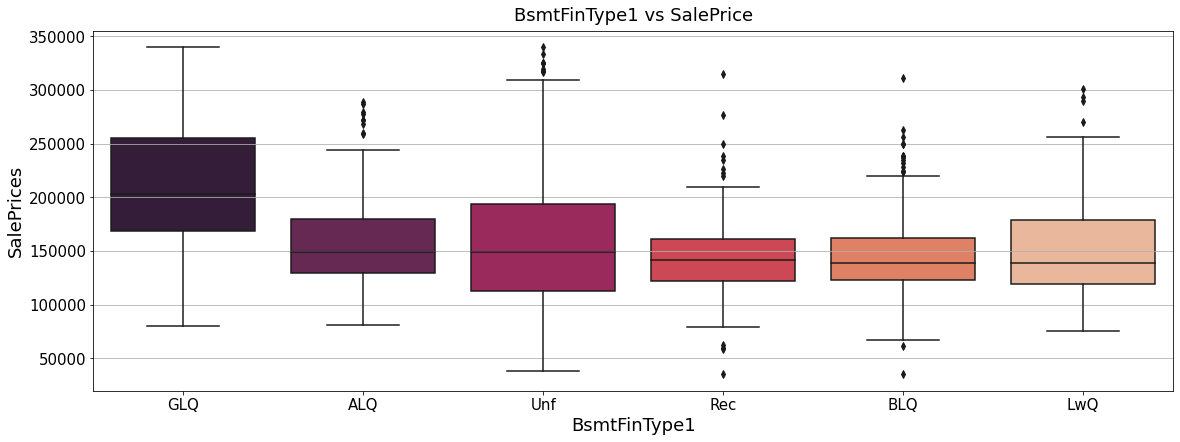

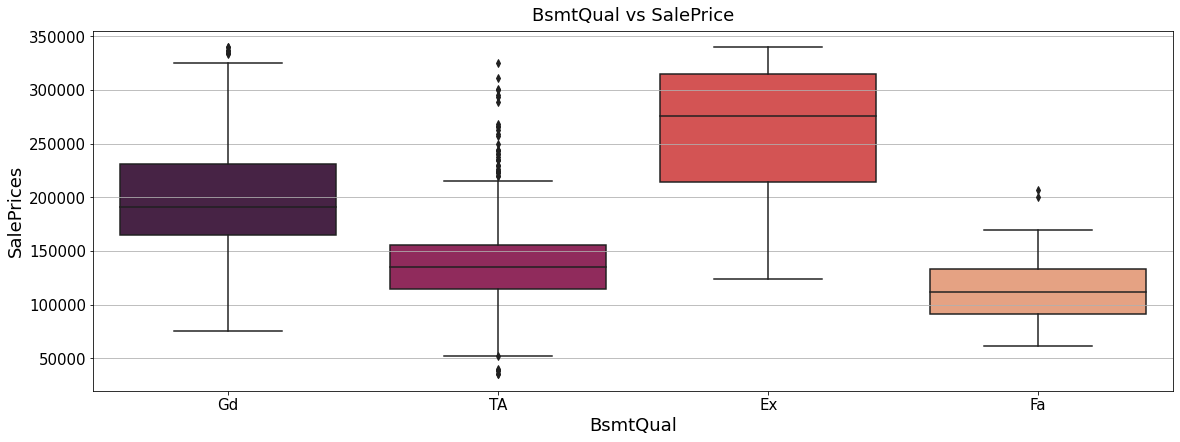

In [65]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data10, x = 'BsmtFinType1', y = 'SalePrice', palette = 'rocket')
axis.set_title('BsmtFinType1 vs SalePrice', fontsize = 18, pad = 10)
axis.set_xlabel('BsmtFinType1', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data10, x = 'BsmtQual', y = 'SalePrice', palette = 'rocket')
axis.set_title('BsmtQual vs SalePrice', fontsize = 18, pad = 10)
axis.set_xlabel('BsmtQual', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')


Graph 'BsmtFinType1 vs SalePrice' shows that houses with Good Living Quarters cost more, however, for the other classifications, it seems to have no effect at all, since median is almost the same value for each classification.

Graph 'BsmtQual vs SalePrice' shows that houses with Excellent basement cost more, Typical and Fair cost almost the same.

I am not sure about the impact of both variables, so, it will be determined later using feature selection.

In [66]:
to_analyse.drop(['BsmtQual', 'BsmtFinType1'], axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenQual', 'Fireplaces',
       'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

#### 4 - houses with better kitchen quality cost more

In [67]:
data11 = data[['KitchenQual', 'SalePrice']]
data11.head()

,KitchenQual,SalePrice
0,Gd,208500
1,TA,181500
2,Gd,223500
3,Gd,140000
4,Gd,250000


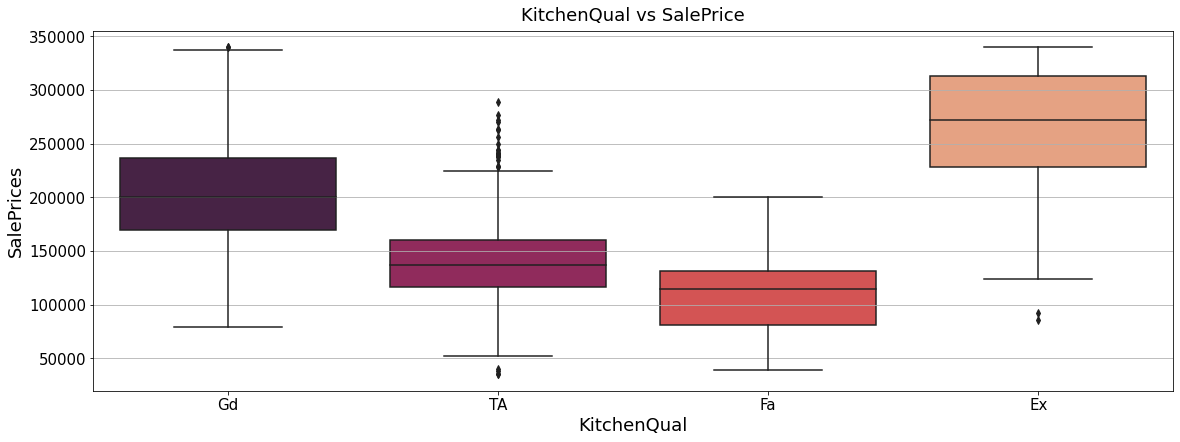

In [68]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data11, x = 'KitchenQual', y = 'SalePrice', palette = 'rocket')
axis.set_title('KitchenQual vs SalePrice', fontsize = 18, pad = 10)
axis.set_xlabel('KitchenQual', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')


Houses with excelent kitchen quality have higher prices and fair condition have lower. It seems to be an important attribute to define its prices.

In [69]:
to_analyse.drop(['KitchenQual'], axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'Fireplaces', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold',
       'SalePrice'],
      dtype='object')

### Outside house based:

#### 1 - the neighborhood has influence in price

In [70]:
data12 = data[['SalePrice', 'Neighborhood']]
data12.head()

,SalePrice,Neighborhood
0,208500,CollgCr
1,181500,Veenker
2,223500,CollgCr
3,140000,Crawfor
4,250000,NoRidge


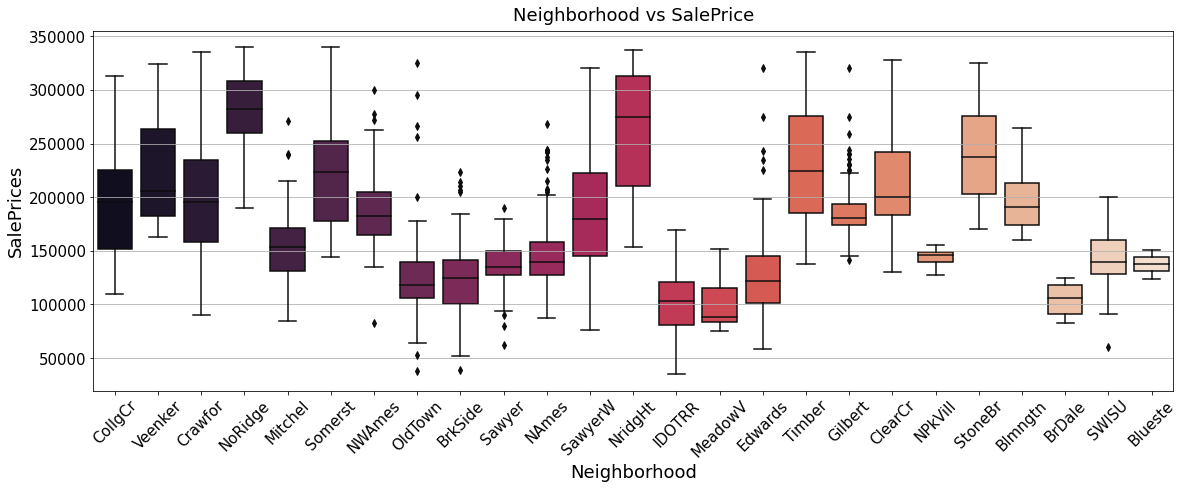

In [71]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data12, x = 'Neighborhood', y = 'SalePrice', palette = 'rocket')
axis.set_title('Neighborhood vs SalePrice', fontsize = 18, pad = 10)
axis.set_xlabel('Neighborhood', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')
plt.xticks(rotation = 45);

Neighborhood is an important variable because we can see cleary that the price chances according to the place. So, this variable will be considered in the model.

In [72]:
to_analyse.drop(['Neighborhood'], axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'Fireplaces', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### 2 - Lot configuration and LotArea have influence in price


From the description, we have:
    
    LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
    
    LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
    
    LotFrontage: Linear feet of street connected to property

    LotArea: Lot size in square feet

In [73]:
data13 = data[['LotFrontage', 'LotArea', 'LotShape', 'LotConfig', 'SalePrice']]
data13.head()

,LotFrontage,LotArea,LotShape,LotConfig,SalePrice
0,65.0,8450,Reg,Inside,208500
1,80.0,9600,Reg,FR2,181500
2,68.0,11250,IR1,Inside,223500
3,60.0,9550,IR1,Corner,140000
4,84.0,14260,IR1,FR2,250000


In [74]:
min(data['LotFrontage'])

21.0

In [75]:
max(data['LotFrontage'])

313.0

In [76]:
(313 - 21)/2

146.0

In [77]:
step = range(21, 313, 2)
step = np.asarray(step)

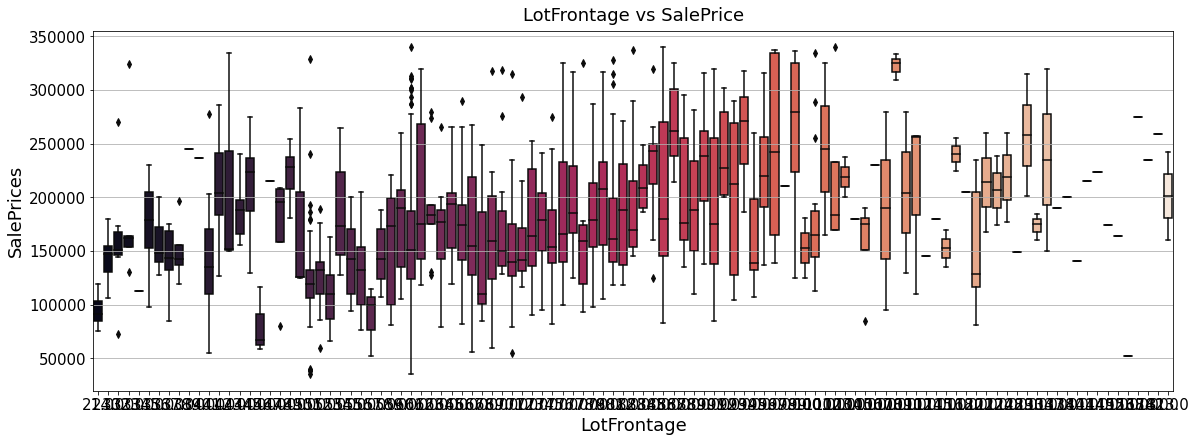

In [78]:


fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data13, x = 'LotFrontage', y = 'SalePrice', palette = 'rocket')
axis.set_title('LotFrontage vs SalePrice', fontsize = 18, pad = 10)
axis.set_xlabel('LotFrontage', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

# plt.xticks(step, rotation = 45);
plt.show()

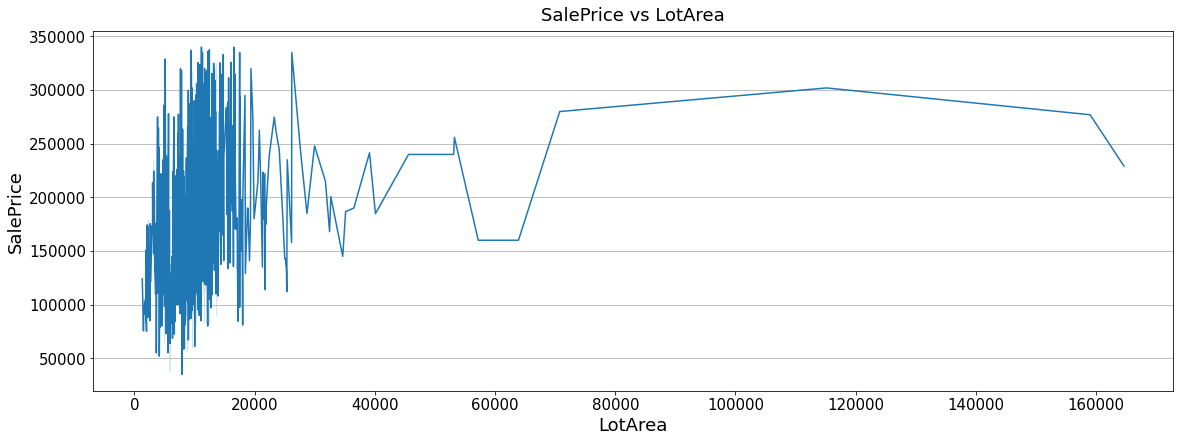

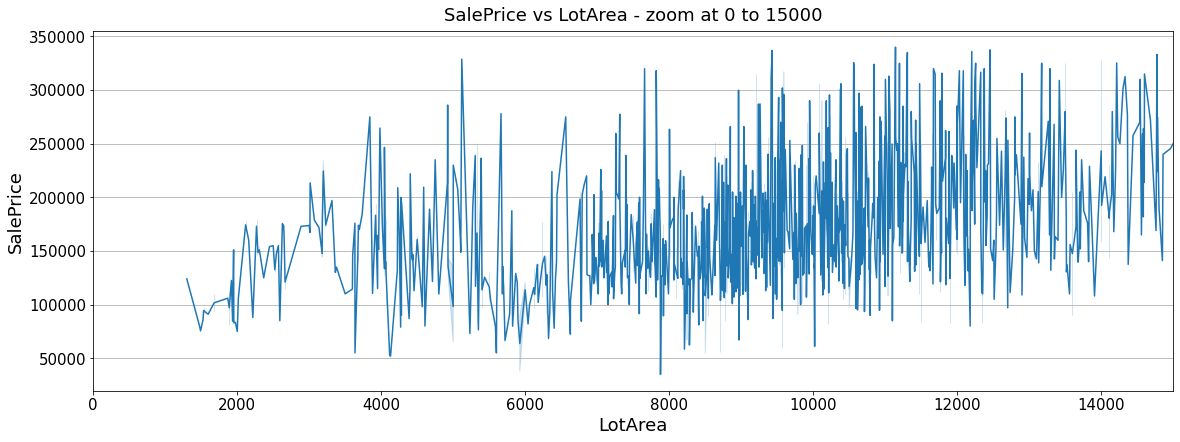

In [79]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.lineplot(data = data13, x = 'LotArea', y = 'SalePrice')
axis.set_title('SalePrice vs LotArea', fontsize = 18, pad = 10)
axis.set_xlabel('LotArea', fontsize = 18)
axis.set_ylabel('SalePrice', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y');

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.lineplot(data = data13, x = 'LotArea', y = 'SalePrice', palette = 'rocket')
axis.set_title('SalePrice vs LotArea - zoom at 0 to 15000', fontsize = 18, pad = 10)
axis.set_xlabel('LotArea', fontsize = 18)
axis.set_ylabel('SalePrice', fontsize = 18)
axis.set_xlim(0, 15000)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y');



In [80]:
print(f"The larger LotArea is {data['LotArea'].idxmax()} square feet and its value is ${data.loc[data['LotArea'].idxmax(), 'SalePrice']}.")

The larger LotArea is 335 square feet and its value is $228950.


LotFrontage seems to have no influence over SalePrice, we see that for high values of LotFrontage, the price can be either high or low, thus, this is not an important variable.

LotArea also seems to have no influence over SalePrice. It is possible to see that there is a large variation up to 15000 square feet. This variation is not so intense after this value, but the house with the larger LotArea does not have the higher price.
So, this is not an important variable

In [81]:
to_analyse.drop(['LotArea', 'LotFrontage'], axis = 1, inplace = True)
to_analyse.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'Foundation', 'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### 3 - lot shape has influence in price

From the description, we have that:

    LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

In [82]:
data14 = data[['SalePrice', 'LotShape']].copy()

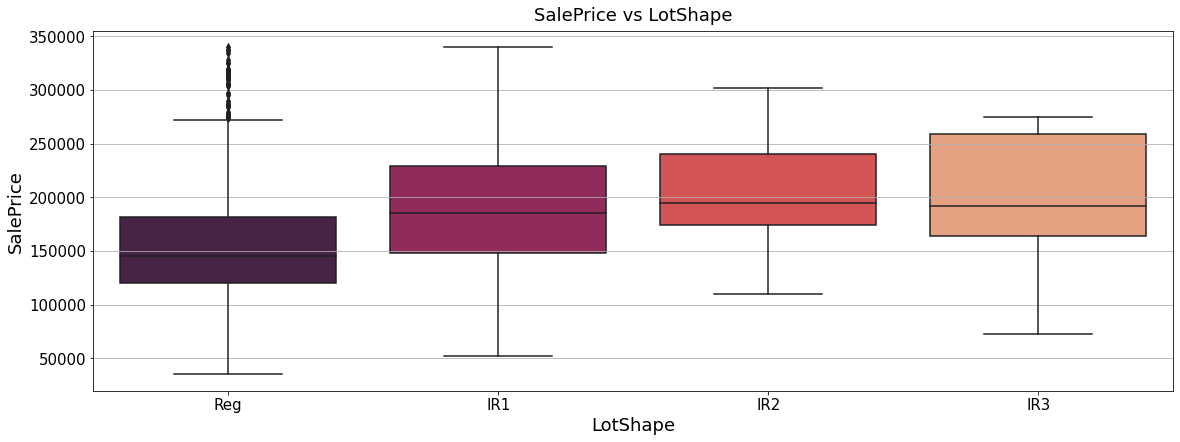

In [83]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data13, x = 'LotShape', y = 'SalePrice', palette = 'rocket')
axis.set_title('SalePrice vs LotShape', fontsize = 18, pad = 10)
axis.set_xlabel('LotShape', fontsize = 18)
axis.set_ylabel('SalePrice', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y');


Irregular lot shape doesn't make houses cost less, in fact, thar is no such large differente bettwen prices for different lotshape. This variable was considered not important for the ML model.

#### 4 - more than one frontage makes the price increase

From the description, we have:

    LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

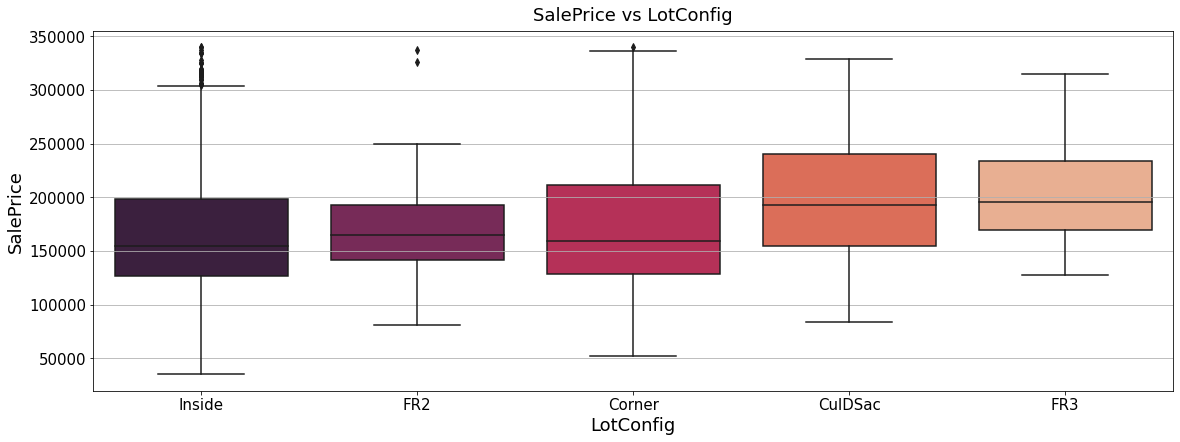

In [84]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data13, x = 'LotConfig', y = 'SalePrice', palette = 'rocket')
axis.set_title('SalePrice vs LotConfig', fontsize = 18, pad = 10)
axis.set_xlabel('LotConfig', fontsize = 18)
axis.set_ylabel('SalePrice', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y');

Houses with two or three frontage don't have higher prices. In fact, LotConfig doesn't apply a significative influence over the price.

## Feature Selection Itself

This section, I will make feature selection using 'SelectKBest'. I will sort the score values in descending order just for us to observe which attributes have the higher and the lower scores. Higher the score means that more that variable explains the behavior of dependent variable.

Before going to Feature Selection Itself, we need to adjust the categorical variables. To do this, I will use the function prepare_input() that I created. First, this function uses OrdinalEncoder() to transform the categorical discrete variables into intengers. After that, to avoid that the machine learning algorithm attributes a weight, we use OneHotEncoder() and, then, the StandardScaler().

We need to separate the categorical variables into two dataframes, one for discrete, other for ordinal. There isn't much to do here, we will have to do it manually.

In [85]:
numerical = data.select_dtypes(include = ['int64', 'float64']).reset_index()
categorical = data.select_dtypes(exclude = ['int64', 'float64']).reset_index()
numerical.drop('index', axis = 1, inplace = True)
categorical.drop('index', axis = 1, inplace = True)
numerical.tail()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice,tot_rooms_no_bedrooms
1394,1456,62.0,7917,6,5,1999,2000,0.0,0,953,...,1,1999.0,2,460,0,40,8,2007,175000,4
1395,1457,85.0,13175,6,6,1978,1988,119.0,790,589,...,2,1978.0,2,500,349,0,2,2010,210000,4
1396,1458,66.0,9042,7,9,1941,2006,0.0,275,877,...,2,1941.0,1,252,0,60,5,2010,266500,5
1397,1459,68.0,9717,5,6,1950,1996,0.0,49,0,...,0,1950.0,1,240,366,0,4,2010,142125,3
1398,1460,75.0,9937,5,6,1965,1965,0.0,830,136,...,0,1965.0,1,276,736,68,6,2008,147500,3


In [86]:
categorical.tail()

,MSSubClass,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,GarageType,GarageFinish
1394,60,RL,Reg,Inside,Gilbert,2Story,Gable,VinylSd,VinylSd,None,TA,PConc,Gd,No,Unf,Ex,TA,Attchd,RFn
1395,20,RL,Reg,Inside,NWAmes,1Story,Gable,Plywood,Plywood,Stone,TA,CBlock,Gd,No,ALQ,TA,TA,Attchd,Unf
1396,70,RL,Reg,Inside,Crawfor,2Story,Gable,CemntBd,CmentBd,None,Ex,Stone,TA,No,GLQ,Ex,Gd,Attchd,RFn
1397,20,RL,Reg,Inside,NAmes,1Story,Hip,MetalSd,MetalSd,None,TA,CBlock,TA,Mn,GLQ,Gd,Gd,Attchd,Unf
1398,20,RL,Reg,Inside,Edwards,1Story,Gable,HdBoard,HdBoard,None,Gd,CBlock,TA,No,BLQ,Gd,TA,Attchd,Fin


In [87]:
cols = ['LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'GarageFinish']
categorical_ordinal = data[cols].reset_index()
categorical_ordinal.drop('index', axis = 1, inplace = True)
categorical_discrete = data.select_dtypes(exclude = ['int64', 'float64']).reset_index()
categorical_discrete.drop(cols, axis = 1, inplace = True)
categorical_discrete.drop('index', axis = 1, inplace = True)
categorical_discrete.tail()

,MSSubClass,MSZoning,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtFinType1,GarageType
1394,60,RL,Inside,Gilbert,2Story,Gable,VinylSd,VinylSd,None,PConc,Unf,Attchd
1395,20,RL,Inside,NWAmes,1Story,Gable,Plywood,Plywood,Stone,CBlock,ALQ,Attchd
1396,70,RL,Inside,Crawfor,2Story,Gable,CemntBd,CmentBd,None,Stone,GLQ,Attchd
1397,20,RL,Inside,NAmes,1Story,Hip,MetalSd,MetalSd,None,CBlock,GLQ,Attchd
1398,20,RL,Inside,Edwards,1Story,Gable,HdBoard,HdBoard,None,CBlock,BLQ,Attchd


In [88]:
categorical_ordinal.tail()

,LotShape,ExterQual,BsmtQual,BsmtExposure,HeatingQC,KitchenQual,GarageFinish
1394,Reg,TA,Gd,No,Ex,TA,RFn
1395,Reg,TA,Gd,No,TA,TA,Unf
1396,Reg,Ex,TA,No,Ex,Gd,RFn
1397,Reg,TA,TA,Mn,Gd,Gd,Unf
1398,Reg,Gd,TA,No,Gd,TA,Fin


In [89]:
map_lotshape = {'Reg' : 3, 'IR1' : 2, 'IR2': 1, 'IR3' : 0}
map_exterqual = {'Ex': 4, 'Gd' : 3, 'TA' : 2, 'Fa': 1, 'Po': 0}
map_bsmtqual = {'Ex': 4, 'Gd' : 3, 'TA' : 2, 'Fa': 1, 'Po': 0}
map_bsmtexposure = {'Gd': 4, 'Av' : 3, 'Mn' : 2, 'No': 1, 'NA': 0}
map_heatingqc = {'Ex': 4, 'Gd' : 3, 'TA' : 2, 'Fa': 1, 'Po': 0}
map_kitchequal = {'Ex': 4, 'Gd' : 3, 'TA' : 2, 'Fa': 1, 'Po': 0}
map_garagefinish = {'Fin' : 3, 'RFn' : 2, 'Unf': 1, 'NA' : 0}

categorical_ordinal['LotShape'] = categorical_ordinal['LotShape'].map(map_lotshape, na_action = None)
categorical_ordinal['ExterQual'] = categorical_ordinal['ExterQual'].map(map_exterqual, na_action = None)
categorical_ordinal['BsmtQual'] = categorical_ordinal['BsmtQual'].map(map_bsmtqual, na_action = None)
categorical_ordinal['BsmtExposure'] = categorical_ordinal['BsmtExposure'].map(map_bsmtexposure, na_action = None)
categorical_ordinal['HeatingQC'] = categorical_ordinal['HeatingQC'].map(map_exterqual, na_action = None)
categorical_ordinal['KitchenQual'] = categorical_ordinal['KitchenQual'].map(map_kitchequal, na_action = None)
categorical_ordinal['GarageFinish'] = categorical_ordinal['GarageFinish'].map(map_garagefinish, na_action = None)


categorical_ordinal.tail()

,LotShape,ExterQual,BsmtQual,BsmtExposure,HeatingQC,KitchenQual,GarageFinish
1394,3,2,3,1,4,2,2
1395,3,2,3,1,2,2,1
1396,3,4,2,1,4,3,2
1397,3,2,2,2,3,3,1
1398,3,3,2,1,3,2,3


We can see that the conversion was successfully done. Now, we will treat the discrete categorical variables.

In [90]:
categorical_discrete_final = categorical_discrete.values
categorical_discrete_final = prepare_input(categorical_discrete)
categorical_discrete_final[0]

array([ 0.78253346, -0.04675744,  0.60452531, -1.17744131,  1.02741913,
       -0.46099841,  0.75085752,  0.76003266, -1.26399735,  0.86015956,
       -0.43230228, -0.69403696])

In [91]:
categorical_discrete_final = pd.DataFrame(data = categorical_discrete_final)
categorical_discrete_final.columns = ['MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtFinType1', 'GarageType']
categorical_final = categorical_ordinal.merge(categorical_discrete_final, how = 'left', left_index=True, right_index=True).reset_index()
categorical_final.drop('index', axis = 1, inplace = True)
categorical_final.tail()

,LotShape,ExterQual,BsmtQual,BsmtExposure,HeatingQC,KitchenQual,GarageFinish,MSSubClass,MSZoning,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtFinType1,GarageType
1394,3,2,3,1,4,2,2,0.782533,-0.046757,0.604525,-0.678126,1.027419,-0.460998,0.750858,0.760033,0.410560,0.860160,1.183346,-0.694037
1395,3,2,3,1,2,2,1,-0.618137,-0.046757,0.604525,0.320504,-0.534362,-0.460998,-0.188162,-0.088559,2.085117,-0.516686,-1.509401,-0.694037
1396,3,4,2,1,4,3,2,1.062668,-0.046757,0.604525,-1.011003,1.027419,-0.460998,-1.440188,-1.502879,0.410560,3.613851,-0.432302,-0.694037
1397,3,2,2,2,3,3,1,-0.618137,-0.046757,0.604525,-0.012373,-0.534362,2.014767,-0.501168,-0.654287,0.410560,-0.516686,-0.432302,-0.694037
1398,3,3,2,1,3,2,3,-0.618137,-0.046757,0.604525,-0.844565,-0.534362,-0.460998,-1.127181,-1.220015,0.410560,-0.516686,-0.970852,-0.694037


In [92]:
data_final = numerical.merge(categorical_final, how = 'left', left_index=True, right_index=True)
data_final.drop(['Id', 'SalePrice'], axis = 1, inplace = True)
data_final['SalePrice'] = numerical['SalePrice'].copy()
data_final.tail()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtFinType1,GarageType,SalePrice
1394,62.0,7917,6,5,1999,2000,0.0,0,953,953,...,-0.678126,1.027419,-0.460998,0.750858,0.760033,0.410560,0.860160,1.183346,-0.694037,175000
1395,85.0,13175,6,6,1978,1988,119.0,790,589,1542,...,0.320504,-0.534362,-0.460998,-0.188162,-0.088559,2.085117,-0.516686,-1.509401,-0.694037,210000
1396,66.0,9042,7,9,1941,2006,0.0,275,877,1152,...,-1.011003,1.027419,-0.460998,-1.440188,-1.502879,0.410560,3.613851,-0.432302,-0.694037,266500
1397,68.0,9717,5,6,1950,1996,0.0,49,0,1078,...,-0.012373,-0.534362,2.014767,-0.501168,-0.654287,0.410560,-0.516686,-0.432302,-0.694037,142125
1398,75.0,9937,5,6,1965,1965,0.0,830,136,1256,...,-0.844565,-0.534362,-0.460998,-1.127181,-1.220015,0.410560,-0.516686,-0.970852,-0.694037,147500


I will just check the columns present in the data_final dataframe, just to be sure that there isn't any column with no name.

You can see that I used '.reset_index()' functon all the time and checked the tail of the dataframe. That is because when we dropped the outliers, some index were erased, so, to be sure that we were lining up the correct rows, I did all the process. 

Ok, now, let's check the scores. For that, I will use the select_features() function created for me. This function uses SelectKBest and mutual_info_regression.



In [93]:
X_final = data_final.iloc[:, :-1].values
y_final = data_final.iloc[:, -1].values

In [94]:
fs = select_features(data_final, y_final)
c = 0
att = []
score = []
for i in data_final.columns:
    if i != 'SalePrice':
        att.append(i)
        score.append(fs.scores_[c])
        c +=1
        
df_score = pd.DataFrame(list(zip(att, score)), columns = ['Attribute','Score'])
df_score = df_score.sort_values(by = 'Score', ascending = False)
df_score

,Attribute,Score
2,OverallQual,0.496564
37,Neighborhood,0.480475
12,GrLivArea,0.412286
4,YearBuilt,0.338139
21,GarageArea,0.325040
20,GarageCars,0.308412
28,ExterQual,0.300102
9,TotalBsmtSF,0.294481
32,KitchenQual,0.282453
34,MSSubClass,0.281080


I will choose the attributes which the score are higher than 0.23:

In [95]:
final_cols = []
c = 0
for value in df_score['Score'].values:
    if value > 0.22:
        final_cols.append(df_score.iloc[c, 0])
        c += 1
final_cols

['OverallQual',
 'Neighborhood',
 'GrLivArea',
 'YearBuilt',
 'GarageArea',
 'GarageCars',
 'ExterQual',
 'TotalBsmtSF',
 'KitchenQual',
 'MSSubClass',
 'BsmtQual',
 'GarageFinish',
 '1stFlrSF',
 'FullBath',
 'GarageYrBlt']

Let's compare the features selectted by the SelectKBest and those we talked earlier.

1 - YearBuilt has a relatively high influence and will be considered for the final model. In my analysis, I said it won't be considered for the ML model, but, since the algorithm showed a high score for it, I will consider.

2 - YearRemodAdd doesn't enter in our ML model, but, we saw that it plays no influence in price.

3 - OverallQual showed to be the most valuable attribute for define SalePrice, we had discussed that it was an important variable, but the algorithm helps us to understand the true weight of the variable.

4 - OverallCond has a very little influence in SalePrice, so, it will not be considered in the final ML.

5 - GarageType also has a very little influence in SalePrice, as discussed before.

6 - GarageArea and GarageCars, they are related with each other and both apply a large influence in SalePrice.

7 - BedroomAbvGr, tot_rooms_no_bedrooms and TotRmsAbvGrd won't be cosidered in the final ML model. I thought that tot_rooms_no_bedrooms would apply some influence, but TotRmsAbvGrd showed to have more influence in it.

8 - We had considered that only FullBath applies an influence in SalePrice, and it turned out we were right.

9 - BsmtQual showed to be important for our model, when we analysed, we weren't sure about its impact in SalePrice, now, we can see that it applies.

10 - KitchenQual is important and will be considered.

11 - Neighborhood has a large influence over SalePrice, it is the second more important variable.

12 - LotArea, LotFrontage, LotShape and LotConfig don't are important, so, it won't be considered in the final ML model.

Let's see if it is possible to cut some more variables using correlation matrix.

In [96]:
data_final = data_final[final_cols].copy()
data_final['SalePrice'] = numerical['SalePrice'].copy()
data_final.tail()

,OverallQual,Neighborhood,GrLivArea,YearBuilt,GarageArea,GarageCars,ExterQual,TotalBsmtSF,KitchenQual,MSSubClass,BsmtQual,GarageFinish,1stFlrSF,FullBath,GarageYrBlt,SalePrice
1394,6,-0.678126,1647,1999,460,2,2,953,2,0.782533,3,2,953,2,1999.0,175000
1395,6,0.320504,2073,1978,500,2,2,1542,2,-0.618137,3,1,2073,2,1978.0,210000
1396,7,-1.011003,2340,1941,252,1,4,1152,3,1.062668,2,2,1188,2,1941.0,266500
1397,5,-0.012373,1078,1950,240,1,2,1078,3,-0.618137,2,1,1078,1,1950.0,142125
1398,5,-0.844565,1256,1965,276,1,3,1256,2,-0.618137,2,3,1256,1,1965.0,147500


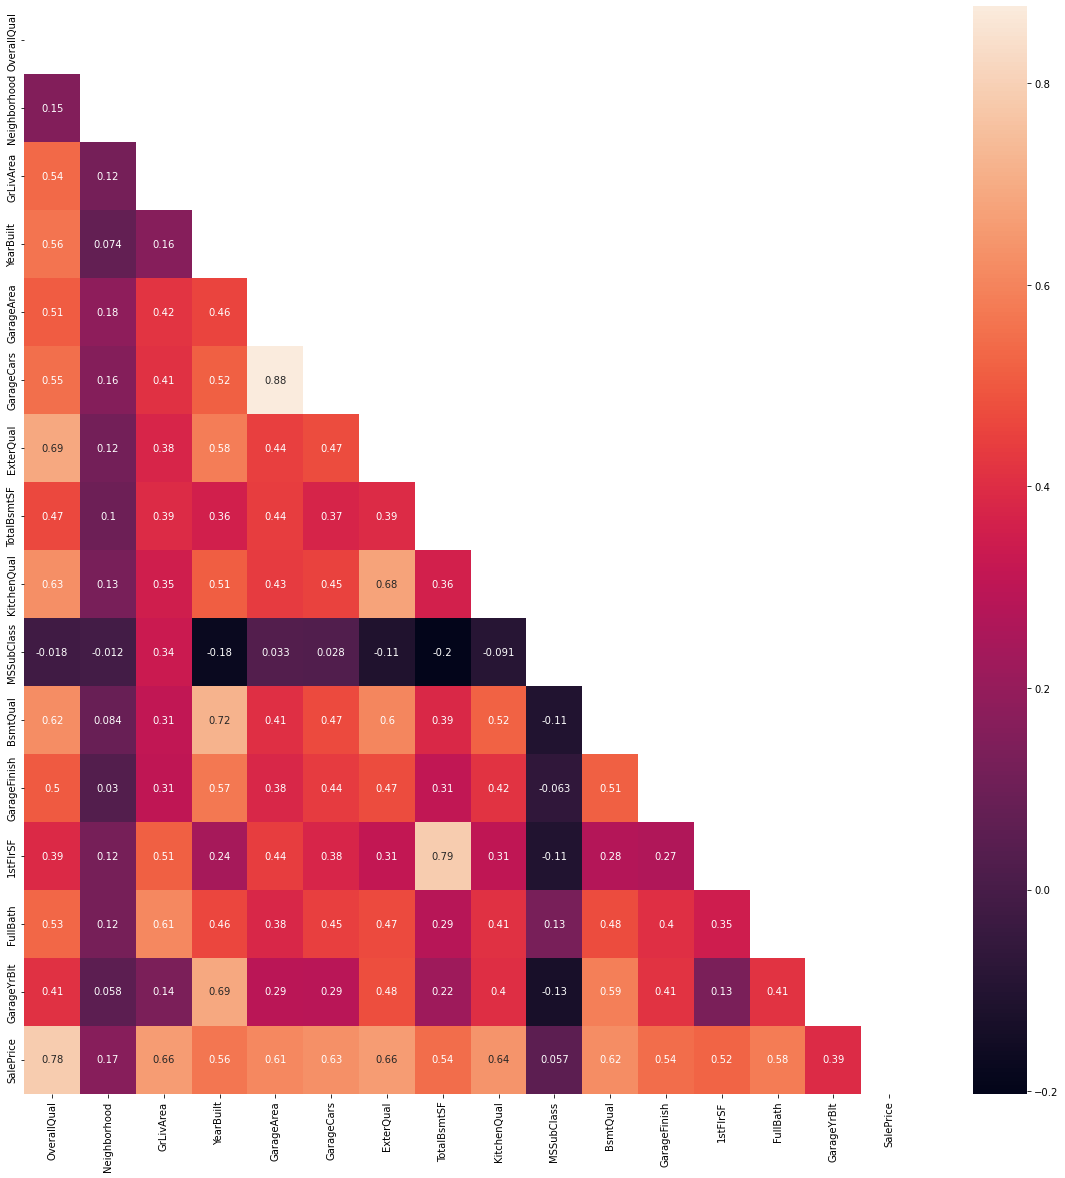

In [97]:
plt.figure(figsize=(20, 20))

corr = data_final.corr(method = 'pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask = mask,annot = True);

GarageCars and GarageArea are really related. They correlation is 0.88, so, we can eliminate one of them.

TotalBsmtSF and 1stFIrSF also have a high correlation, about 0.72, so, we can also eliminate one of them.

Let's analyse them.

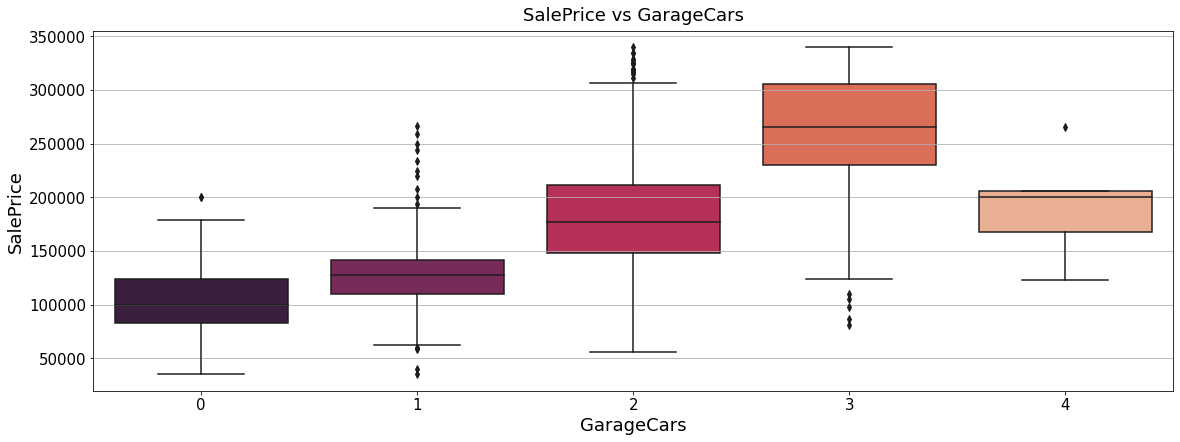

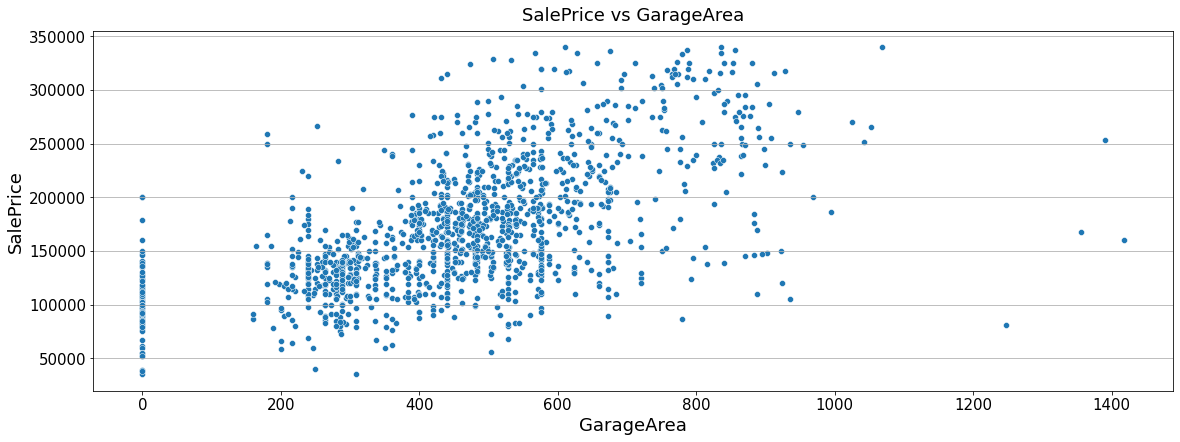

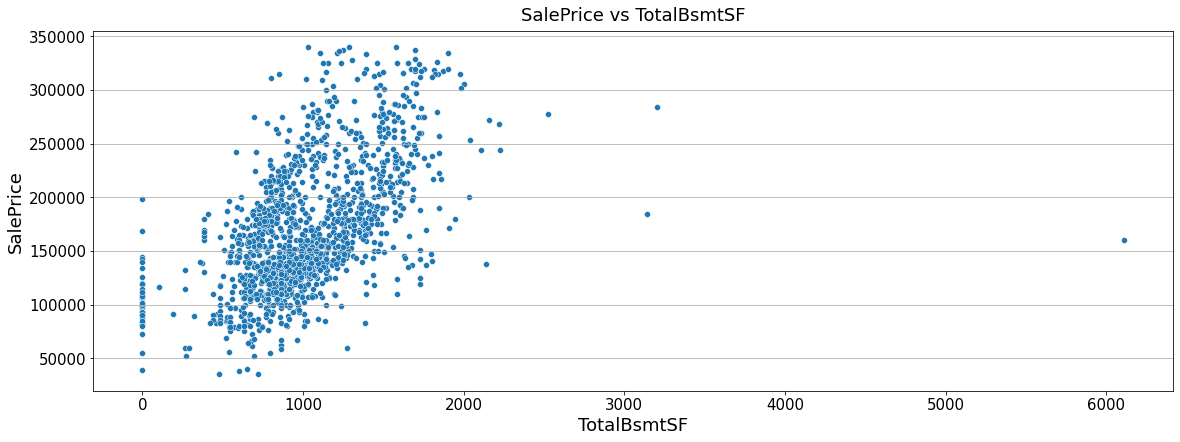

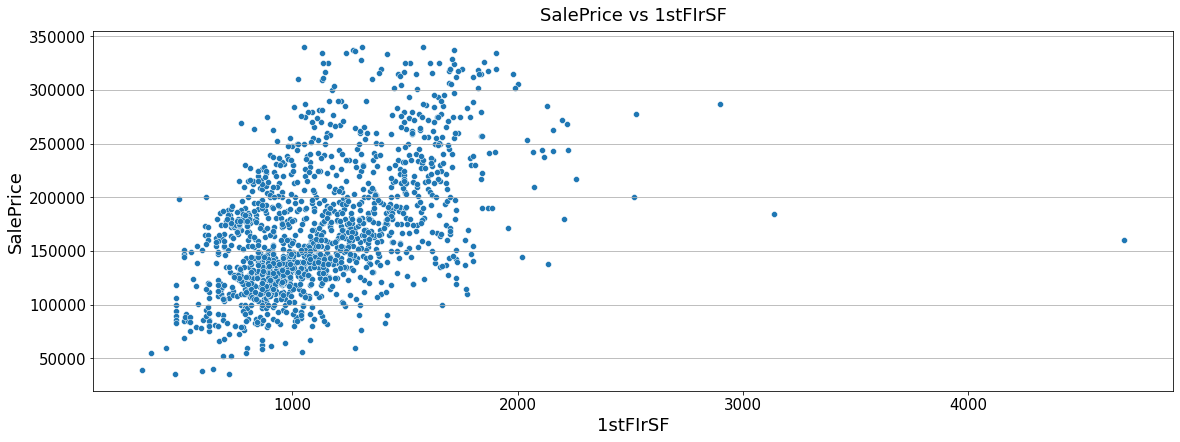

In [98]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.boxplot(data = data_final, x = 'GarageCars', y = 'SalePrice', palette = 'rocket')
axis.set_title('SalePrice vs GarageCars', fontsize = 18, pad = 10)
axis.set_xlabel('GarageCars', fontsize = 18)
axis.set_ylabel('SalePrice', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y');

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.scatterplot(data = data_final, x = 'GarageArea', y = 'SalePrice', palette = 'rocket')
axis.set_title('SalePrice vs GarageArea', fontsize = 18, pad = 10)
axis.set_xlabel('GarageArea', fontsize = 18)
axis.set_ylabel('SalePrice', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y');

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.scatterplot(data = data_final, x = 'TotalBsmtSF', y = 'SalePrice', palette = 'rocket')
axis.set_title('SalePrice vs TotalBsmtSF', fontsize = 18, pad = 10)
axis.set_xlabel('TotalBsmtSF', fontsize = 18)
axis.set_ylabel('SalePrice', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y');

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.scatterplot(data = data_final, x = '1stFlrSF', y = 'SalePrice', palette = 'rocket')
axis.set_title('SalePrice vs 1stFIrSF', fontsize = 18, pad = 10)
axis.set_xlabel('1stFIrSF', fontsize = 18)
axis.set_ylabel('SalePrice', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y');

As GarageArea and TotalBsmtSF will be dropped due to the amount of dots in x = zero.

In [99]:
data_final.drop(['GarageArea', 'TotalBsmtSF'], axis = 1, inplace = True)
data_final.tail()

,OverallQual,Neighborhood,GrLivArea,YearBuilt,GarageCars,ExterQual,KitchenQual,MSSubClass,BsmtQual,GarageFinish,1stFlrSF,FullBath,GarageYrBlt,SalePrice
1394,6,-0.678126,1647,1999,2,2,2,0.782533,3,2,953,2,1999.0,175000
1395,6,0.320504,2073,1978,2,2,2,-0.618137,3,1,2073,2,1978.0,210000
1396,7,-1.011003,2340,1941,1,4,3,1.062668,2,2,1188,2,1941.0,266500
1397,5,-0.012373,1078,1950,1,2,3,-0.618137,2,1,1078,1,1950.0,142125
1398,5,-0.844565,1256,1965,1,3,2,-0.618137,2,3,1256,1,1965.0,147500


In [100]:
data_final.shape

(1399, 14)

Finally, we are ready to start our ML models. At the beginnig, we had 1460 rows and 79 attributes. Now, we have only 1399 rows and 12 attributes and we are sure they are the best variables. It is a reduction of 86% in independet variable amount.



## Machine Learning Models

Let's create our X and y datasets and separe in train data and test data. But first, I will create the seed, using the function seed(42). The $X$ values are related with the attributes and the $Y$ values are related with the SalePrice values.

Then, I will split into train data and test data, the test size will be 25% of the hole data, and the train data will be with 75%.

In [101]:
seed = seed(42)

In [102]:
X_data = data_final.iloc[:, :-1].values
y_data = data_final.iloc[:, -1].values
X_data.shape, y_data.shape

((1399, 13), (1399,))

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.25, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1049, 13), (1049,), (350, 13), (350,))

### Simple Linear Regression

In [104]:
slr = LinearRegression()
slr.fit(X_train, y_train)
pred_slr = slr.predict(X_test)

result_slr = error_tab('Simple Linear Regression', y_test, pred_slr)
result_slr

,Model Name,MAE,MAPE,RMSE
0,Simple Linear Regression,18655.795207,0.122279,24408.095406


In [105]:
cv_slr = cross_val_tab('Simple Linear Regression', slr, X_train, y_train)
cv_slr

,Simple Linear Regression
Mean,0.757983
STD,0.071075


### Lasso Linear Regression

In [106]:
lr_lasso = Lasso(alpha = 5, random_state = seed)
lr_lasso.fit(X_train, y_train)
pred_lr_lasso = lr_lasso.predict(X_test)

result_lr_lasso = error_tab('Lasso Linear Regression', y_test, pred_lr_lasso)
result_lr_lasso

,Model Name,MAE,MAPE,RMSE
0,Lasso Linear Regression,18657.244451,0.122284,24410.569241


In [107]:
cv_lr_lasso = cross_val_tab('Lasso Linear Regression', lr_lasso, X_train, y_train)
cv_lr_lasso

,Lasso Linear Regression
Mean,0.758013
STD,0.071052


### Ridge Linear Regression

In [108]:
lr_ridge = Ridge(alpha = 5, random_state = seed)
lr_ridge.fit(X_train, y_train)
pred_lr_ridge = lr_lasso.predict(X_test)

result_lr_ridge = error_tab('Ridge Linear Regression', y_test, pred_lr_ridge)
result_lr_ridge

,Model Name,MAE,MAPE,RMSE
0,Ridge Linear Regression,18657.244451,0.122284,24410.569241


In [109]:
cv_lr_ridge = cross_val_tab('Ridge Linear Regression', lr_ridge, X_train, y_train)
cv_lr_ridge

,Ridge Linear Regression
Mean,0.758204
STD,0.070862


### Decision Tree Regressor

In [110]:
dtc = DecisionTreeRegressor(criterion='absolute_error', random_state = seed)
dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_test)

result_dtc = error_tab('Decision Tree Regressor', y_test, pred_dtc)
result_dtc

,Model Name,MAE,MAPE,RMSE
0,Decision Tree Regressor,24189.721429,0.158278,33917.270905


In [111]:
cv_dtc = cross_val_tab('Decision Tree Regressor', dtc, X_train, y_train)
cv_dtc

,Decision Tree Regressor
Mean,0.687644
STD,0.024523


### Random Forest Regressor

In [112]:
rfr_start = time.time()
rfr = RandomForestRegressor(random_state = seed)
rfr.fit(X_train, y_train)
pred_rfr = rfr.predict(X_test)

result_rfr = error_tab('Random Forest Regressor', y_test, pred_rfr)
rfr_end = time.time()
print(f'Total time for rfr: {rfr_end - rfr_start}')
result_rfr

Total time for rfr: 0.610443115234375


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,15967.919769,0.106606,22854.207125


In [113]:
cv_rfr = cross_val_tab('Random Forest Regressor', rfr, X_train, y_train)
cv_rfr

,Random Forest Regressor
Mean,0.832037
STD,0.021399


### XGBoost

In [114]:
xgb_reg_start = time.time()
xgb_reg = xgb.XGBRegressor(n_estimators= 100,
                            eta = 0.2,
                            max_depth = 10,
                            subsample = 0.7, random_state = seed)
xgb_reg.fit(X_train, y_train)
pred_xgb_reg = xgb_reg.predict(X_test)

result_xgb_reg = error_tab('XGBoost', y_test, pred_xgb_reg)
xgb_reg_end = time.time()
print(f'Total time for xgb_reg: {xgb_reg_end - xgb_reg_start}')
result_xgb_reg

Total time for xgb_reg: 1.829890251159668


,Model Name,MAE,MAPE,RMSE
0,XGBoost,15819.389933,0.103136,21654.152357


In [115]:
cv_xgb_reg = cross_val_tab('XGBoost', xgb_reg, X_train, y_train)
cv_xgb_reg

,XGBoost
Mean,0.832076
STD,0.011565


## Comparing the models

### Errors

With the models done, I think that the best way to analyse which one has the lowest erros is building a dataframe and ordering it by each error, just as follows.

In [116]:
comp = pd.concat([result_slr, result_lr_lasso, result_lr_ridge, result_dtc, result_rfr, result_xgb_reg])
comp.sort_values('MAPE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost,15819.389933,0.103136,21654.152357
0,Random Forest Regressor,15967.919769,0.106606,22854.207125
0,Simple Linear Regression,18655.795207,0.122279,24408.095406
0,Lasso Linear Regression,18657.244451,0.122284,24410.569241
0,Ridge Linear Regression,18657.244451,0.122284,24410.569241
0,Decision Tree Regressor,24189.721429,0.158278,33917.270905


In [117]:
comp.sort_values('MAE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost,15819.389933,0.103136,21654.152357
0,Random Forest Regressor,15967.919769,0.106606,22854.207125
0,Simple Linear Regression,18655.795207,0.122279,24408.095406
0,Lasso Linear Regression,18657.244451,0.122284,24410.569241
0,Ridge Linear Regression,18657.244451,0.122284,24410.569241
0,Decision Tree Regressor,24189.721429,0.158278,33917.270905


In [118]:
comp.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost,15819.389933,0.103136,21654.152357
0,Random Forest Regressor,15967.919769,0.106606,22854.207125
0,Simple Linear Regression,18655.795207,0.122279,24408.095406
0,Lasso Linear Regression,18657.244451,0.122284,24410.569241
0,Ridge Linear Regression,18657.244451,0.122284,24410.569241
0,Decision Tree Regressor,24189.721429,0.158278,33917.270905


XGBoost and Random Forest Regressor (RFR) have, without a doubt, the best result. XGBoost has the lowest error for every error we had analyzed, while RFR has the second lower erros.

As the results were very colse to each others, I also tried to analyse processing time, but they were also similar. We will check others results to make a conclusion.

### Cross Validation

We will again built a dataframe and ordering it by the mean of Cross Validation Scores, just as follows.

In [119]:
cv_final = cv_slr.merge(cv_lr_lasso, left_index = True, right_index = True).merge(cv_lr_ridge, left_index = True, right_index = True).merge(cv_dtc, left_index = True, right_index = True).merge(cv_rfr, left_index = True, right_index = True).merge(cv_xgb_reg, left_index = True, right_index = True)
cv_final = cv_final.T
cv_final.sort_values('Mean', ascending = False)

,Mean,STD
XGBoost,0.832076,0.011565
Random Forest Regressor,0.832037,0.021399
Ridge Linear Regression,0.758204,0.070862
Lasso Linear Regression,0.758013,0.071052
Simple Linear Regression,0.757983,0.071075
Decision Tree Regressor,0.687644,0.024523


XGBoost has the higher score, the lowest STD and, yet, the lowest erros. So, without a doubt, XGBoost is the best model for our problem.

## Performance

To analyse the performance and compare each other, I will create two dataframe, one for XGBoost and the other for RFR. I will create some columns as residuals (i.e, real value - predicted value) and a column for percentage variation (i.e, (real value - predicted value) / real value).

After that, I will calculate the sum for residuals and the mean for percentage variation. Afther that I will calculate the difference bettwen than, using absolute(RFR_results) - absolute(XGBoost_results), so, if this value is higher than zero, RFR_results are higher than XGBoost_results, if this value is lower than zero, RFR_results are lower than XGBoost_results.

In [120]:
X_test_xgb_reg = pd.DataFrame(X_test)
y_test_xgb_reg = pd.DataFrame(y_test)

final_result_xgb_reg = X_test_xgb_reg.copy()
final_result_xgb_reg['SalePrice'] = y_test_xgb_reg.copy()
final_result_xgb_reg['Predicted'] = pred_xgb_reg

final_result_xgb_reg['y - predicted'] = final_result_xgb_reg['SalePrice'] - final_result_xgb_reg['Predicted']
final_result_xgb_reg['Percent'] = abs(final_result_xgb_reg['y - predicted'] / final_result_xgb_reg['SalePrice'])
final_result_xgb_reg.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,SalePrice,Predicted,y - predicted,Percent
0,5.0,0.819819,1812.0,1900.0,2.0,2.0,3.0,-0.898272,3.0,1.0,1032.0,2.0,1999.0,140000,128026.609375,11973.390625,0.085524
1,5.0,-0.012373,1053.0,1959.0,1.0,3.0,3.0,-0.618137,2.0,2.0,1053.0,1.0,1959.0,145500,137695.062500,7804.937500,0.053642
2,6.0,-1.177441,1456.0,2005.0,2.0,3.0,3.0,0.782533,3.0,3.0,728.0,2.0,2005.0,163990,178890.843750,-14900.843750,0.090864
3,5.0,-0.844565,1214.0,1965.0,2.0,2.0,2.0,-0.618137,2.0,1.0,1214.0,1.0,1965.0,140000,130587.460938,9412.539062,0.067232
4,6.0,1.319134,1217.0,1980.0,1.0,2.0,2.0,-1.458540,3.0,2.0,626.0,1.0,1980.0,120000,127593.171875,-7593.171875,0.063276


In [121]:
X_test_pred_rfr = pd.DataFrame(X_test)
y_test_pred_rfr = pd.DataFrame(y_test)

final_result_pred_rfr = X_test_pred_rfr.copy()
final_result_pred_rfr['SalePrice'] = y_test_pred_rfr.copy()
final_result_pred_rfr['Predicted'] = pred_rfr

final_result_pred_rfr['y - predicted'] = final_result_pred_rfr['SalePrice'] - final_result_pred_rfr['Predicted']
final_result_pred_rfr['Percent'] = abs(final_result_pred_rfr['y - predicted'] / final_result_pred_rfr['SalePrice'])
final_result_pred_rfr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,SalePrice,Predicted,y - predicted,Percent
0,5.0,0.819819,1812.0,1900.0,2.0,2.0,3.0,-0.898272,3.0,1.0,1032.0,2.0,1999.0,140000,144227.74,-4227.74,0.030198
1,5.0,-0.012373,1053.0,1959.0,1.0,3.0,3.0,-0.618137,2.0,2.0,1053.0,1.0,1959.0,145500,135406.50,10093.50,0.069371
2,6.0,-1.177441,1456.0,2005.0,2.0,3.0,3.0,0.782533,3.0,3.0,728.0,2.0,2005.0,163990,178601.16,-14611.16,0.089098
3,5.0,-0.844565,1214.0,1965.0,2.0,2.0,2.0,-0.618137,2.0,1.0,1214.0,1.0,1965.0,140000,127573.74,12426.26,0.088759
4,6.0,1.319134,1217.0,1980.0,1.0,2.0,2.0,-1.458540,3.0,2.0,626.0,1.0,1980.0,120000,132361.80,-12361.80,0.103015


In [122]:
print('For XGBoost Regressor')

print(f"Sum of Residuals: {final_result_xgb_reg['y - predicted'].sum():.3f}")

print(f"Percent variation: {final_result_xgb_reg['Percent'].mean() * 100:.3f}")

print('--' * 20)

print('For Random Forest Regressor')

print(f"Sum of Residuals: {final_result_pred_rfr['y - predicted'].sum():.3f}")

print(f"Percent variation: {final_result_pred_rfr['Percent'].mean() * 100:.3f}")

print('--' * 20)
print('Differences: RFR - XGBoost')

print(f"Mean Residuals: {abs(final_result_pred_rfr['y - predicted'].sum()) - abs(final_result_xgb_reg['y - predicted'].sum())}")

print(f"Percent variation: {abs(final_result_pred_rfr['Percent'].mean() * 100) - abs(final_result_xgb_reg['Percent'].mean() * 100)}")

For XGBoost Regressor
Mean Residuals: -350914.383
Percent variation: 10.314
----------------------------------------
For Random Forest Regressor
Mean Residuals: -614261.532
Percent variation: 10.661
----------------------------------------
Differences: RFR - XGBoost
Mean Residuals: 263347.1492827381
Percent variation: 0.3470418475500967


The sum of residuals for XGBoost is way higher than for RFR, which means taht the loss for RFR is lower. The percentage variantion is a very little higher for RFR, but it irrelevant. 

Let's now analyse the residuals distribution for each one.

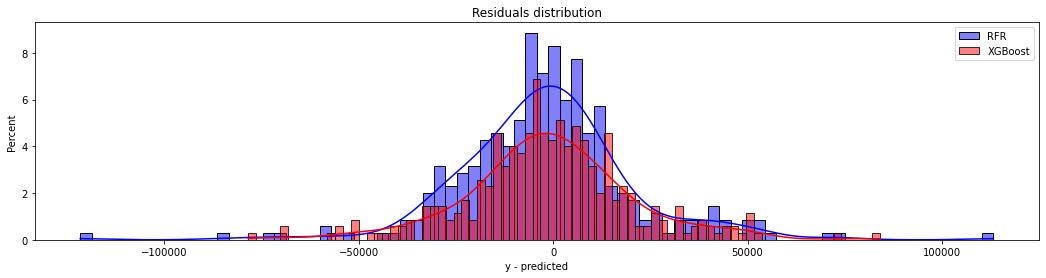

In [132]:
plt.figure(figsize=(18, 4))

sns.histplot(data = final_result_pred_rfr, x = 'y - predicted', label = 'RFR', color = 'blue', stat = 'percent', bins = 80, kde = True)
sns.histplot(data = final_result_xgb_reg, x = 'y - predicted', label = 'XGBoost', color = 'red', stat = 'percent', bins = 80, kde = True)

plt.title('Residuals distribution')
plt.legend();


As we can see, both have a normal distribution for the residuals, however, RFR has a straighter distribution, i.e., the standard deviation is lower and their values are more concentrated near zero, so, in general, the residuals values for RFR are lower than for XGBoost.

For all the reasons presented here, I think that our XGBoost Regressor is the one with the best results, and it will be the chosen model.

Now, let's plot the graphs real vs predicted and compare the values of our model with the real values. Next, I will plot a graph for the difference between real and predicted.

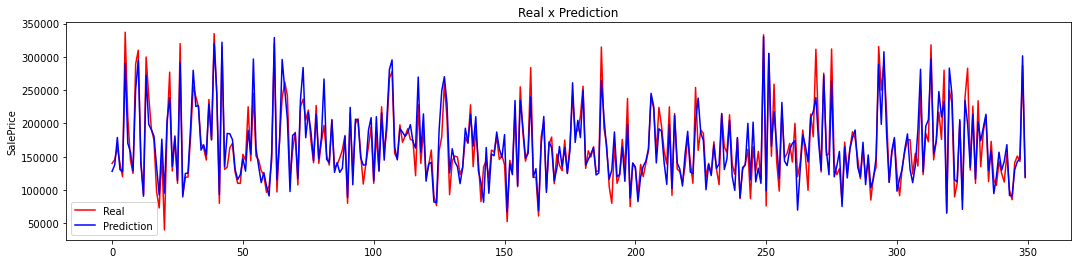

In [129]:
plt.figure(figsize=(18, 4))

sns.lineplot(data = final_result_xgb_reg, x = final_result_xgb_reg.index, y = 'SalePrice', label = 'Real', color = 'red')
sns.lineplot(data = final_result_xgb_reg, x = final_result_xgb_reg.index, y = 'Predicted', label = 'Prediction', color = 'blue')

plt.title('Real x Prediction');


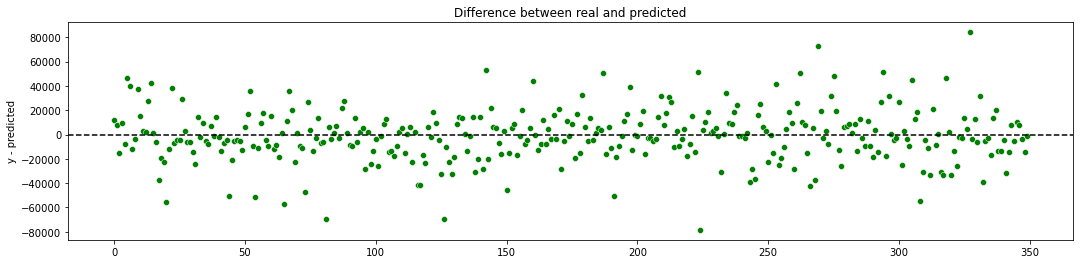

In [127]:
plt.figure(figsize=(18, 4))

sns.scatterplot(data = final_result_xgb_reg, x = final_result_pred_rfr.index, y = 'y - predicted', color = 'green')
plt.title('Difference between real and predicted')
plt.axhline(0, linestyle = '--', color = 'black');

Our model fits very well with the test data, and that is a very good result! The differences between the velues are very concentred at about [-10000, 10000].

## Conclusion

In this project we wanted to create a model to predict the house prices based in 79 attributes. The idea was to test some types and see the difference between then.
Using the 79 attributes is absurd because it will make the model too complex, slow and very susceptible for overfitting. So, we needed to analyse what attributes were important and what were not. 

Using exploratory data analysis it was possible to see the presence of outliers, and it was possible to remove them.

We had to create some hyposesis and analysed each one of then, because maybe a new variable could be created and could also be important. Afther the hypotesis tests, we used SelectkBest to see the impact of the attributes in the SalePrice. We selected those with score higher than 0.22, this is an important step, because low score means that that variable doesn't contribute anything for SalePrice chance, therefore, must be deleted.

After that, it is good to use correçation matrix to see how each variable are related to each other. That way, we were able to delete more two variable!

At the end we had 13 variables, a decrease of 83% in the number of attributes.

Finally, we created and tested several models, and, after lots of analysis, we decidade that Random Forest Regressor was the best model for our dataset.

It was my first DS project and I am really proud of each. I could learn and see that machine learning is complex, and it is not just go out creating models and 'playing with data'. It is way more complex than that, and, now, I am more confident and more able to make a good and decent analysis.